<a href="https://colab.research.google.com/github/esemsc-dbk24/Faultless-Seismology/blob/main/task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 4 Notebook

## Getting Started

### Task Instructions

**Objective: Evaluate understanding and proficiency in the following**
* Data Compression techniques applied to Big Datasets
* Fusing and Assimilation of real-world observed data into a Big Data analytics framework
* Analysis and interpretation of compressed and assimilated data to device meaningful insights

**We are provided**
* Model Data (already pre-processed)
  * Ferguson_fire_train: training data obtained from wildfires simulations
  * Ferguson_fire_test: similar to Ferguson_fire_train but obtained from different simulations
  * Ferguson_fire_background: model data to be used for the data assimilation
    * Note: model data already selected in time steps corresponding to satellites observed data
* Satellite data (already pre-processed)
  * Ferguson_fire_obs: Observation data at different days after ignition (only one trajectory)

**Task 4: - Data Assimilation with linear compression (25%):**
* Given the wildfire data streams from satellites containing information about the historical wildfire Ferguson (California, US – 2018) and including the burned area as variable.
* Assimilate the satellite data (Ferguson_fire_obs) into the model data (Ferguson_fire_background) for a real-time adjustment.
* Requirements: Use a data assimilation model (eg. Kalman Filter, BLUE, Variational model, etc.) that integrates diverse wildfire data sources in a compressed space. Perform Data Assimilation in a reduced space obtained by a linear compression algorithm (e.g., PCA, EOFs, etc.)
1. Motivate your choice of covariance matrices R and B. 10%
2. Test the assimilation model and submit both code and results including:
• MSE in the reduced space and execution time. 5%
• MSE in the physical space (after decompression) and execution time. 10%

### <font color=orange> Google Colab Specific </font>

This section should only be run if the user is running the code in Google Colab. Otherwise this section can be skipped or commented out.

In [94]:
# mounting to drive
from google.colab import drive
drive.mount('/content/drive')

# drive.mount("/content/drive", force_remount=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<font color=red>` !! NOTE !! `</font > - Be sure to change the project_dir variable to reflect your environment path

In [95]:
# Navigate to your project folder inside Drive
import os
project_dir = '/content/drive/MyDrive/BDA_Assessment'
os.chdir(project_dir)
print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/BDA_Assessment


In [96]:
# checking what version of tensorflow used and if GPU available
!pip install tensorflow     #needed if not running on GPU
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: []


### Importing Libraries & Utilities

In [151]:
# Standard library imports
from pathlib import Path
import datetime
import time
import os
import re
import gc
import pickle
import json
from typing import Dict, Any
from copy import deepcopy
import joblib
from numpy.linalg import cond
from itertools import product
import seaborn as sns



# Third-party numerical/scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, r2_score
)
from sklearn.decomposition import PCA, KernelPCA
from scipy.optimize import minimize

In [98]:
# Utility functions
import sys
sys.path.append('./utils')  # ensure your utils folder is in the path

import data_exploration_functions
import visualisation_functions
import model_development_functions
import metrics_and_scores_functions
import loading_and_saving
import model_identification_and_validation_functions

## Assessment Work

In [99]:
random_state = 42

# Define results folder for logs and metrics
results_folder_path = 'results_and_metrics'
os.makedirs(results_folder_path, exist_ok=True)

# Path for assimilation experiment logs (CSV)
task4_assimilation_log_path = os.path.join(results_folder_path, 'task4_assimilation_log_linear.csv')

# Optional: Folder for best fused outputs or key model variants (e.g. pickled latent data)
assimilation_output_dir = 'task4_selected_outputs'
os.makedirs(assimilation_output_dir, exist_ok=True)

### Helper Functions

Though many functions are implemented separately and stored in the various .py files in the ./utils folder. Many of the specific functions for this task are defined in the cells below

In [100]:
def generate_assimilation_key(config):
    """
    Function to generate a unique key for assimilation experiments.

    Parameters:
    ----------
        config: dict
            Dictionary containing assimilation configuration parameters.

    Returns:
    -------
        str
            Assimilation key based on configuration parameters.
            Meant to be used as a unique identifier for the assimilation experiment.

    """
    return f"assimilate_{config['assimilation_method']}_R-{config['R_type']}_B-{config['B_type']}_Sigma-{config['sigma_method']}"

In [101]:
def mse(a, b):
    """
    Computes the mean squared error between two arrays. (MSE)

    Parameters:
    ----------
        a: np.ndarray
            First array
        b: np.ndarray
            Second array
    Returns:
    -------
        float
            Mean squared error between a and b
    """
    return np.square(a - b).mean()

In [102]:
def estimate_sigma(latents1, latents2, method='fixed'):
    """
    Returns sigma value based on method.

    Parameters:
    ----------
        latents1: np.ndarray
            First latent representation (vector)
        latents2: np.ndarray
            Second latent representation (vector)
        method: str
            Method to estimate sigma.
            Options: 'fixed', 'std', 'mse'
            default: 'fixed'

    Returns:
    -------
        tuple: (float, float)
            Sigma values for latents1 and latents2
    """
    if method == 'std':
        return np.std(latents1), np.std(latents2)
    elif method == 'mse':
        err = np.square(latents1 - latents2).mean()
        return np.sqrt(err), np.sqrt(err)
    else:
        return 0.01, 0.01

#### Assimilation Functions

In [103]:
def blue_assimilation(x_b, y, B, R):
    """
    Performs BLUE assimilation in latent space

    Parameters:
    ----------
        x_b: np.ndarray
            Background latent representation (vector)
        y: np.ndarray
            Observation latent representation (vector)
        B: np.ndarray
            Background covariance matrix
        R: np.ndarray
            Observation covariance matrix

    Returns:
    -------
        x_b: np.ndarray
            Updated background latent representation (vector)

    """
    delta = y - x_b
    gain = B @ safe_inverse(B + R)
    return x_b + gain @ delta


In [104]:
def kalman_assimilation(x_b, y, B, R):
    """
    Performs Kalman assimilation in latent space

    Parameters:
    ----------
        x_b: np.ndarray
            Background latent representation (vector)
        y: np.ndarray
            Observation latent representation (vector)
        B: np.ndarray
            Background covariance matrix
        R: np.ndarray
            Observation covariance matrix

    Returns:
    -------
        x_b: np.ndarray
            Updated background latent representation (vector)
    """
    # Kalman filter is identical to BLUE in this static setting
    return blue_assimilation(x_b, y, B, R)


In [105]:
def enkf_assimilation(x_b, y, B, R, n_ensemble=20):
    """
    Performs Ensemble Kalman assimilation in latent space

    Parameters:
    ----------
        x_b: np.ndarray
            Background latent representation (vector)
        y: np.ndarray
            Observation latent representation (vector)
        B: np.ndarray
            Background covariance matrix
        R: np.ndarray
            Observation covariance matrix
        n_ensemble: int
            Number of ensemble members

    Returns:
    -------
        x_b: np.ndarray
            Updated background latent representation (vector)

    """
    # Generate ensembles by adding noise from B and R to background and observation
    ensemble = x_b + np.random.multivariate_normal(np.zeros_like(x_b), B, n_ensemble)
    obs_perturbed = y + np.random.multivariate_normal(np.zeros_like(y), R, n_ensemble)

    # Compute ensemble means
    x_mean = ensemble.mean(axis=0)
    y_mean = obs_perturbed.mean(axis=0)

    # Compute anomalies (deviation from mean)
    A = ensemble - x_mean
    D = obs_perturbed - y_mean

    # Covariance approximations from anomalies
    Pxy = A.T @ D / (n_ensemble - 1)
    Pyy = D.T @ D / (n_ensemble - 1)

    # Kalman gain and update
    K = Pxy @ safe_inverse(Pyy)

    return x_mean + K @ (y - y_mean)


In [106]:
def three_d_var_assimilation(x_b, y, B, R):
    """
    Performs 3D variational assimilation in latent space

    Parameters:
    ----------
        x_b: np.ndarray
            Background latent representation (vector)
        y: np.ndarray
            Observation latent representation (vector)
        B: np.ndarray
            Background covariance matrix
        R: np.ndarray
            Observation covariance matrix

    Returns:
    -------
        x_b: np.ndarray
            Updated background latent representation (vector)
    """

    # Variational assimilation using minimization of a cost function
    def cost_function(x):
        return 0.5 * ((x - x_b).T @ safe_inverse(B) @ (x - x_b)) + \
               0.5 * ((y - x).T @ safe_inverse(R) @ (y - x))
    # using native minimize from sklearn
    res = minimize(cost_function, x_b, method='L-BFGS-B')
    return res.x

In [107]:
def run_assimilation_step(x_b, y, B, R, model, assimilation_step_method='BLUE'):
    """
    Runs a single assimilation step and tracks separate timing for assimilation and decoding.

    Parameters:
    -----------
      x_b : np.ndarray
          Background latent representation
      y : np.ndarray
          Observation latent representation
      B : np.ndarray
          Background covariance matrix
      R : np.ndarray
          Observation covariance matrix
      model : object
          Compression model
      assimilation_step_method : str
          Assimilation method to use. Options: 'BLUE', 'Kalman', 'EnKF', '3DVar'
    Returns:
    --------
      x_a : np.ndarray
          Assimilated latent state
      metrics : dict
          Dictionary with latent/physical MSEs and two separate timing metrics
    """
    # Time assimilation step
    t0 = time.time()
    if assimilation_step_method == 'BLUE':
        x_a = blue_assimilation(x_b, y, B, R)
    elif assimilation_step_method == 'Kalman':
        x_a = kalman_assimilation(x_b, y, B, R)
    elif assimilation_step_method == 'EnKF':
        x_a = enkf_assimilation(x_b, y, B, R)
    elif assimilation_step_method == '3DVar':
        x_a = three_d_var_assimilation(x_b, y, B, R)
    else:
        raise NotImplementedError(f"Assimilation method '{assimilation_step_method}' not implemented")
    t1 = time.time()

    # Time reconstruction step
    recon_assimilated = model.inverse_transform(x_a[np.newaxis, :])[0]
    recon_obs = model.inverse_transform(y[np.newaxis, :])[0]
    t2 = time.time()

    # Metrics
    metrics = {
        'latent_mse': mse(x_a, y),
        'pixel_mse': mse(recon_assimilated, recon_obs),
        'time_latent_s': t1 - t0,
        'time_pixel_s': t2 - t1,
    }

    return x_a, metrics


In [132]:
def run_assimilation_grid(background_data, observation_data, model, param_grid, log_path, force_run=False):
    """
    Runs assimilation experiments with a grid of parameters.

    Parameters:
    ----------
        background_data: np.ndarray
            Compressed background data
        observation_data: np.ndarray
            Compressed observation data
        model: object
            Compression model
        param_grid: list
            List of dictionaries containing assimilation parameters
        log_path: str
            Path to log file
        force_run: boolean
            Whether to force re-run of existing experiments

    Returns:
    -------
        pd.DataFrame
            DataFrame containing results of assimilation experiments

    """
    results = []
    # Load previous results if available
    if os.path.exists(log_path):
        previous_df = pd.read_csv(log_path)
        previous_keys = set(previous_df['config_key'])
    else:
        previous_keys = set()

    print(f"Running {len(param_grid)} combinations from parameter grid")
    for i, config in enumerate(param_grid):
        print(f"\nConfiguration {i + 1} of {len(param_grid)}:")
        config_key = generate_assimilation_key(config)
        if config_key in previous_keys and not force_run:
            print(f"\t[Skip] Already run: {config_key}")
            continue
        else:
            print(f"\t[Run] {config_key}")

        # Extract config
        assimilation_method = config['assimilation_method']
        R_type = config['R_type']
        B_type = config['B_type']
        sigma_method = config['sigma_method']

        # Compress once per config
        start_compression = time.time()
        background_compressed = model.transform(background_data)
        observation_compressed = model.transform(observation_data)
        compression_time = time.time() - start_compression

        # Estimate uncertainties
        sigma_b, sigma_r = estimate_sigma(background_compressed, observation_compressed, method=sigma_method)
        B = estimate_cov_matrix(background_compressed, method=B_type, sigma=sigma_b)
        R = estimate_cov_matrix(observation_compressed, method=R_type, sigma=sigma_r)

        latent_mse_list = []
        pixel_mse_list = []
        latent_time_list = []
        pixel_time_list = []

        for t in range(background_compressed.shape[0]):
            x_b = background_compressed[t]
            y = observation_compressed[t]

            x_a, metrics = run_assimilation_step(x_b, y, B, R, model, assimilation_step_method=assimilation_method)

            latent_mse_list.append(metrics['latent_mse'])
            pixel_mse_list.append(metrics['pixel_mse'])
            latent_time_list.append(metrics['time_latent_s'])
            pixel_time_list.append(metrics['time_pixel_s'])

        log_entry = {
            'config_key': generate_assimilation_key(config),
            'assimilation_method': assimilation_method,
            'R_type': R_type,
            'B_type': B_type,
            'sigma_method': sigma_method,
            'avg_latent_mse': np.mean(latent_mse_list),
            'avg_pixel_mse': np.mean(pixel_mse_list),
            'avg_time_latent_s': np.mean(latent_time_list),
            'avg_time_pixel_s': np.mean(pixel_time_list),
            'avg_compression_time_s': compression_time / background_compressed.shape[0],  # added
            'compression_ratio': background_compressed.shape[1] / background_data.shape[1]  # added
        }

        print(f"\t{results.append(log_entry)}")
        print(f"\t{loading_and_saving.append_to_results_log(log_entry, log_path, expected_columns=log_entry.keys())}")

    if results:
        return pd.DataFrame(results).sort_values('avg_pixel_mse')
    else:
        None

In [109]:
def run_assimilation(background_data, observation_data, model, R_type="diagonal", B_type="diagonal", sigma_method='fixed'):
    """
    Run assimilation over all time steps for a single config.

    Parameters:
    ----------
        background_data: np.ndarray
            Compressed background data
        observation_data: np.ndarray
            Compressed observation data
        model: object
            Compression model
        R_type: str
            Type of covariance matrix for R
        B_type: str
            Type of covariance matrix for B
        sigma_method: str
            Method to estimate sigma

    Returns:
    -------
        np.ndarray
            Assimilated data
        dict
            Metrics for assimilation
    """
    start_compression = time.time()
    X_b = model.transform(background_data)
    Y_obs = model.transform(observation_data)
    compression_time = time.time() - start_compression

    sigma_b, sigma_r = estimate_sigma(X_b, Y_obs, method=sigma_method)
    B = estimate_cov_matrix(X_b, method=B_type, sigma=sigma_b)
    R = estimate_cov_matrix(Y_obs, method=R_type, sigma=sigma_r)

    latent_mse_list = []
    pixel_mse_list = []
    latent_time_list = []
    pixel_time_list = []
    assimilated_all = []

    for t in range(X_b.shape[0]):
        x_b = X_b[t]
        y = Y_obs[t]

        x_a, metrics = run_assimilation_step(x_b, y, B, R, model, assimilation_step_method='BLUE')

        latent_mse_list.append(metrics['latent_mse'])
        pixel_mse_list.append(metrics['pixel_mse'])
        latent_time_list.append(metrics['time_latent_s'])
        pixel_time_list.append(metrics['time_pixel_s'])

        recon_assimilated = model.inverse_transform(x_a[np.newaxis, :])[0]
        assimilated_all.append(recon_assimilated)

    metrics = {
        'assimilation_method': 'BLUE',
        'R_type': R_type,
        'B_type': B_type,
        'sigma_method': sigma_method,
        'avg_latent_mse': np.mean(latent_mse_list),
        'avg_pixel_mse': np.mean(pixel_mse_list),
        'avg_time_latent_s': np.mean(latent_time_list),
        'avg_time_pixel_s': np.mean(pixel_time_list),
        'avg_compression_time_s': compression_time / X_b.shape[0],
        'compression_ratio': X_b.shape[1] / background_data.shape[1],
    }

    return np.array(assimilated_all), metrics


##### Matrix Operations

In [110]:
def generate_covariance(method, data1, data2=None, fixed_sigma=0.01):
    """
    Returns covariance matrix based on method.

    Parameters:
    ----------
        method: str
            Method to generate covariance matrix.
            Options: 'fixed', 'diag', 'full', 'mse'
        data1: np.ndarray
            First dataset
        data2: np.ndarray
            Second dataset
            Used only for 'mse' method
        fixed_sigmal: float
            Sigma value to use for 'fixed' method
            Default: 0.01

    Returns:
    -------
        np.ndarray
            Covariance matrix

    """
    n = data1.shape[1]

    if method == 'fixed':
        return np.eye(n) * fixed_sigma**2

    elif method == 'diag':
        return np.diag(np.var(data1, axis=0))

    elif method == 'full':
        return np.cov(data1.T)

    elif method == 'mse' and data2 is not None:
        diff = data1 - data2
        mse = np.mean(np.square(diff), axis=0)
        return np.eye(n) * mse.mean()  # isotropic MSE

    else:
        raise ValueError(f"Unsupported covariance method: {method}")

In [111]:
def estimate_cov_matrix(data, method='diagonal', sigma=0.01):
    """
    Returns covariance matrix based on method.

    Parameters:
    ----------
        data: np.ndarray
            Input data
        method: str
            Method to generate covariance matrix.
            Options: 'diagonal', 'np_cov', 'manual_cov'
            default: 'diagonal'
        sigma: float
            Sigma value to use for 'fixed' method
            default: 0.01

    Returns:
    -------
        np.ndarray
            Covariance matrix
    """
    n = data.shape[1]
    if method == 'diagonal':
        return np.eye(n) * sigma
    elif method == 'np_cov':
        return np.cov(data.T)
    elif method == 'manual_cov':
        return covariance_matrix(data.T)
    else:
        raise ValueError(f"Unknown covariance method: {method}")

In [112]:
def safe_inverse(matrix, threshold=1e12):
    """
    Returns the inverse of a matrix.
    Uses pseudo-inverse if matrix is near-singular (ill-conditioned).

    Parameters:
    ----------
        matrix: np.ndarray
            (square matrix) Input matrix
        threshold: float
            Condition number threshold to trigger pinv

    Returns:
    ---------
        np.ndarray
            Inverse of matrix (or pseudo-inverse)
    """
    condition_number = cond(matrix)  # Ratio of largest to smallest singular values

    if condition_number > threshold:
        print(f"[Warning] Matrix is ill-conditioned (cond={condition_number:.2e}). Using pseudo-inverse.")
        return np.linalg.pinv(matrix)
    else:
        return np.linalg.inv(matrix)

In [113]:
def covariance_matrix(X):
    """
    Compute the sample covariance matrix of X.
    Parameters:
    ----------
        X: np.ndarray
            Input data matrix (features x samples)
    Returns:
    -------
        np.ndarray
            Covariance matrix of shape (features, features)
    """
    means = np.mean(X, axis=1, keepdims=True)
    deviations = X - means
    return deviations @ deviations.T / (X.shape[1] - 1)

### Loading the Data

The following cells will be used across all 5 task notebooks

<font color=red>` !! NOTE !! `</font > - Be sure to change the these path variables to reflect your local directory

In [114]:
# Setting path for data files
# Note - even if you have not yet unzipped the datasets, use this cell to set the names and path for the data files that will be extracted
model_background_path = "data/Ferguson_fire_background.npy"
satellite_data_path = "data/Ferguson_fire_obs.npy"
model_train_path = "data/Ferguson_fire_train.npy"
model_test_path = "data/Ferguson_fire_test.npy"

In [115]:
# Unzipping files if needed
# Define paths to the .zip files
zip_files = [
    'data/Ferguson_fire_background.zip',
    'data/Ferguson_fire_train.zip',
    'data/Ferguson_fire_test.zip' ]

# Expected extracted files (modify these if your .zip contains specific filenames)
extracted_files = [
    model_background_path,
    model_train_path,
    model_test_path ]

# Check and unzip only if files don't exist
print("Checking for existing files...")
for zip_path, extracted_path in zip(zip_files, extracted_files):
    if not os.path.exists(extracted_path):
        print(f"\tFile {extracted_path} does not not yet exist. Unzipping {zip_path}...")
        !unzip -q "{zip_path}" -d "data/"
        print(f"....done")
    else:
        print(f"\tFile already exists at {extracted_path}.\tSkipping unzip.")

Checking for existing files...
	File already exists at data/Ferguson_fire_background.npy.	Skipping unzip.
	File already exists at data/Ferguson_fire_train.npy.	Skipping unzip.
	File already exists at data/Ferguson_fire_test.npy.	Skipping unzip.


In [116]:
# Loading the data
model_background_data = np.load(model_background_path)
satellite_data = np.load(satellite_data_path)
model_train_data = np.load(model_train_path)
model_test_data = np.load(model_test_path)

#### Initial Data Reduction (Downcasting Data Types Storage)

In [117]:
### Data Size Reduction
model_background_data = np.load(model_background_path).astype(np.uint8)
model_train_data = np.load(model_train_path).astype(np.uint8)
model_test_data = np.load(model_test_path).astype(np.uint8)
satellite_data = np.load(satellite_data_path).astype(np.uint8)

In [118]:
# Checking the updated size of the datasets that we will be using
data_exploration_functions.print_data_stats(model_background_data, "model_background_data ('Ferguson_fire_background')")
data_exploration_functions.print_data_stats(model_train_data, "model_train_data ('Ferguson_fire_train')")
data_exploration_functions.print_data_stats(model_test_data, "model_test_data ('Ferguson_fire_test')")

Investigating model_background_data ('Ferguson_fire_background')
	Data shape: (5, 256, 256)
	Data type: uint8
	Data size: 0.32768 MB
	Data min: 0
	Data max: 1
	Data mean: 0.080645751953125
	Data std: 0.27229031316783947
	Data median: 0.0
	Data 5th percentile: 0.0
	Data 25th percentile: 0.0
	Data 50th percentile: 0.0
	Data 75th percentile: 1.0
	Data 95th percentile: 1.0
	Unique values in data: [0 1]
	Sparsity of data: 0.91935
Investigating model_train_data ('Ferguson_fire_train')
	Data shape: (12500, 256, 256)
	Data type: uint8
	Data size: 819.20000 MB
	Data min: 0
	Data max: 1
	Data mean: 0.03752271484375
	Data std: 0.19003884001569726
	Data median: 0.0
	Data 5th percentile: 0.0
	Data 25th percentile: 0.0
	Data 50th percentile: 0.0
	Data 75th percentile: 0.0
	Data 95th percentile: 0.0
	Unique values in data: [0 1]
	Sparsity of data: 0.96248
Investigating model_test_data ('Ferguson_fire_test')
	Data shape: (5000, 256, 256)
	Data type: uint8
	Data size: 327.68000 MB
	Data min: 0
	Data ma

#### Transforming Data

In order to implement compression with 1D datasets , we will flatten the required datasets.

In [119]:
# flattening the datasets
model_background_data_flat = model_background_data.reshape(model_background_data.shape[0], -1)
model_train_data_flat = model_train_data.reshape(model_train_data.shape[0], -1)
model_test_data_flat = model_test_data.reshape(model_test_data.shape[0], -1)
model_satellite_data_flat = satellite_data.reshape(satellite_data.shape[0], -1)

print("Shape of datasets:")
print(f"INITIAL - \'model_background_data\' : {model_background_data.shape}\tPOST RESHAPE - \'model_background_data_flat\' : {model_background_data_flat.shape}")
print(f"INITIAL - \'model_train_data\' : {model_train_data.shape}\tPOST RESHAPE - \'model_train_data_flat\' : {model_train_data_flat.shape}")
print(f"INITIAL - \'model_test_data\' : {model_test_data.shape}\t\tPOST RESHAPE - \'model_test_data_flat\' : {model_test_data_flat.shape}")
print(f"INITIAL - \'satellite_data\' : {satellite_data.shape}\t\tPOST RESHAPE - \'model_satellite_data_flat\' : {model_satellite_data_flat.shape}")


Shape of datasets:
INITIAL - 'model_background_data' : (5, 256, 256)	POST RESHAPE - 'model_background_data_flat' : (5, 65536)
INITIAL - 'model_train_data' : (12500, 256, 256)	POST RESHAPE - 'model_train_data_flat' : (12500, 65536)
INITIAL - 'model_test_data' : (5000, 256, 256)		POST RESHAPE - 'model_test_data_flat' : (5000, 65536)
INITIAL - 'satellite_data' : (5, 256, 256)		POST RESHAPE - 'model_satellite_data_flat' : (5, 65536)


#### Additional Data Reduction

Though optional in the previous task, memory becomes a serious concern in the training of dense autoencoders, so we will create a reduced dataset to accomodate these new requirements.

In [120]:
n = 2       # Ever n'th sample to keep - For example, if n=2, it will keep every 2nd sample
train_desired_samples = len(model_train_data_flat) // n       # Number of samples to keep
train_indices = np.linspace(0, len(model_train_data_flat) - 1, train_desired_samples, dtype=int)  # Indices to keep

# Reducing the size of the datasets
model_train_data_flat_reduced = model_train_data_flat[::n][:train_desired_samples]

In [121]:
# Dimensions of original and reduced datasets
print(f"Shape of model_train_data_flat: {model_train_data_flat.shape}")
print(f"Shape of model_train_data_flat_reduced: {model_train_data_flat_reduced.shape}")
print()
# Size of original and reduced datasets
print(f"Size of model_train_data_flat: {model_train_data_flat.nbytes / 1e6:.3f} MB")
print(f"Size of model_test_data_flat: {model_test_data_flat.nbytes / 1e6:.3f} MB")
print(f"Size of model_train_data_flat_reduced: {model_train_data_flat_reduced.nbytes / 1e6:.3f} MB")

Shape of model_train_data_flat: (12500, 65536)
Shape of model_train_data_flat_reduced: (6250, 65536)

Size of model_train_data_flat: 819.200 MB
Size of model_test_data_flat: 327.680 MB
Size of model_train_data_flat_reduced: 409.600 MB


#### Visualizing the Data
We will skip visualising the training and testing data as this is done in the notebook for task1, but we will visualise the satellite data and observation data

[ ! Warning ! ] Requested 10 samples exceeds dataset size of 5. Adjusting to 5.


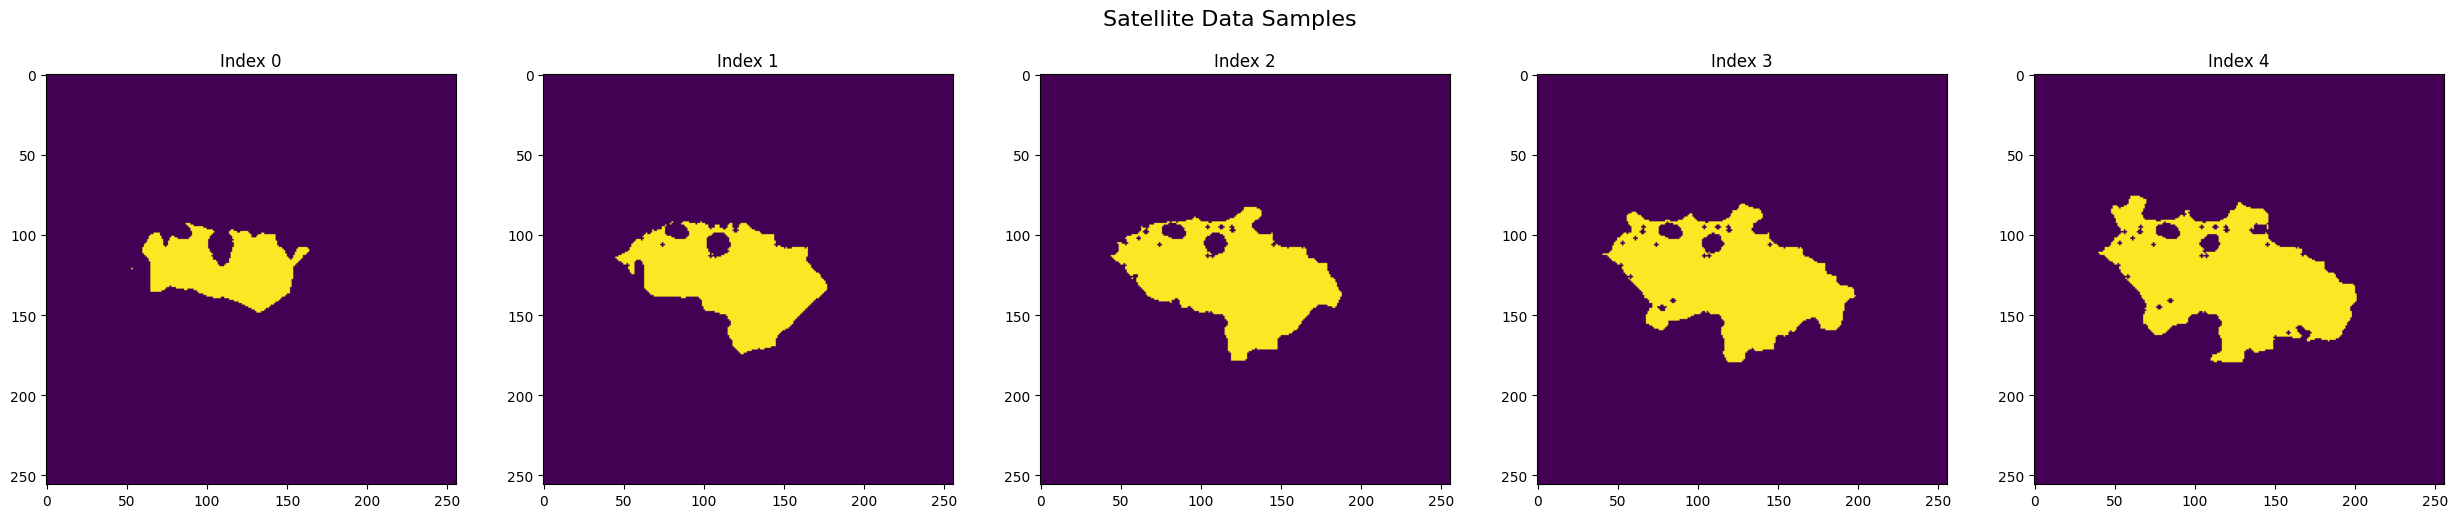

In [122]:
# Satellite data images
# Visualize the first 10 images from the satellite data
visualisation_functions.visualize_samples(satellite_data, n_samples=10, title='Satellite Data Samples', cmap='viridis')

[ ! Warning ! ] Requested 10 samples exceeds dataset size of 5. Adjusting to 5.


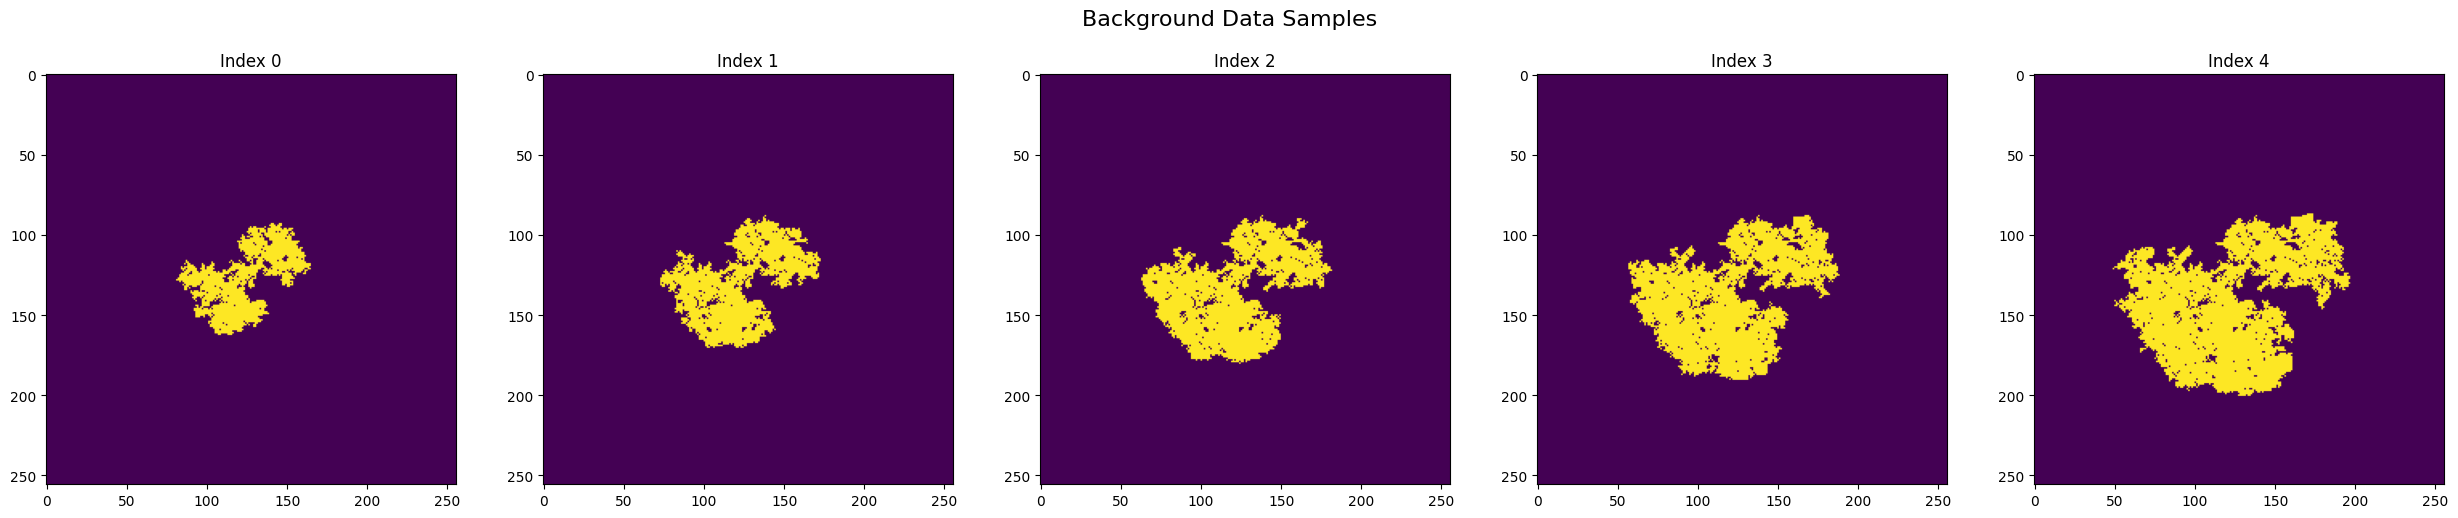

In [123]:
visualisation_functions.visualize_samples(model_background_data, n_samples=10, title='Background Data Samples', cmap='viridis')

### Baseline Approach, Definitions, Hypothesis

---
#### *What we'll explore*

In this task, I evaluate a set of data assimilation techniques for integrating satellite observation data into model forecast data (both pre-compressed), using  linear latent representations. The primary goal is to optimally correct the background model estimate using observed data and improve accuracy in both latent and pixel space.

The assimilation methods explored include:

* BLUE (Best Linear Unbiased Estimator)
* Kalman Filter
* 3DVar (3D Variational Assimilation)
* EnKF (Ensemble Kalman Filter)

All methods are applied in latent space representations built using:
* Final_TruncatedSVD_n250.0_niter-20_tol0.001 (linear)


---
#### *How these methods work*

---
**BLUE Method**

Blue stands for 'Best Linear Unbiased Estimator'

This method works by computing the statistical optimal fusion by assuming the observations are are noisy with known uncertancies.

Here's how it works:

*Given*:
* $\mathbf{x}_b$ is the background (prior forecast) state vector
* $\mathbf{y}$ is the observation vector
* $\mathbf{B}$ is the background error covariance matrix
* $\mathbf{R}$ is the observation error covariance matrix

The analysis state $\mathbf{x}_a$ is computed as:

\begin{equation}
\mathbf{x}_a = \mathbf{x}_b + \mathbf{K} \left( \mathbf{y} - \mathbf{x}_b \right)
\end{equation}

Where the Kalman gain matrix $\mathbf{K}$ is:

\begin{equation}
\mathbf{K} = \mathbf{B} \left( \mathbf{B} + \mathbf{R} \right)^{-1}
\end{equation}

Alternatively, combining the steps:

\begin{equation}
\mathbf{x}_a = \left( \mathbf{R}^{-1} + \mathbf{B}^{-1} \right)^{-1} \left( \mathbf{R}^{-1} \mathbf{y} + \mathbf{B}^{-1} \mathbf{x}_b \right)
\end{equation}


Instead of relying on a single global weight like the weighted average method, BLUE makes use of a covariance matrix R each observation that defines how uncertain each feature (or latent dimension) is.

In simpler terms, it tries to find the best possible balance between the two inputs by weighting each feature individually based on how confident we are in that feature from each observation. If one observation has higher uncertainty for a particular latent feature, BLUE will give it less influence for that feature.

Depending on how you define the covariance matrices R1 and R2, this method can get more or less sophisticated:
* If you assume all features are equally uncertain and uncorrelated, R is just a scaled identity matrix —  basically equivalent to a weighted average, but justified statistically.
* If diagonal matrices with different variances are used for each latent dimension, you can weight features individually.
* If full covariance matrices are used, both the individual uncertainties and how features relate to each other are accounted for — this can make BLUE very powerful in retaining features.

In practice, the BLUE method can outperform weighted average when those covariance matrices are well-estimated, but it's also more sensitive to poor estimates and can become unstable if the matrices are ill-conditioned. It's also more computationally expensive.

So while BLUE is theoretically more powerful, in some cases the extra complexity doesn't always translate into better performance — especially if the data is sparse (like ours) or noise isn't well-characterized.


---
**Kalman Filter (Static)**

In our use case (single step), Kalman is identical in form to BLUE. In dynamic contexts, Kalman recursively updates states and covariances over time. Here we use its single-step version.

---
**3DVar (3D Variational Data Assimilation)**

Instead of a direct formula, 3DVar minimizes a cost function.

\begin{equation}
J(\mathbf{x}) = (\mathbf{x} - \mathbf{x}_b)^T \mathbf{B}^{-1} (\mathbf{x} - \mathbf{x}_b) + (\mathbf{y} - \mathbf{x})^T \mathbf{R}^{-1} (\mathbf{y} - \mathbf{x})
\end{equation}

Where:
* $\mathbf{x}$ is the analysis state to be solved for
* $\mathbf{x}_b$ is the background state
* $\mathbf{y}$ is the observation
* $\mathbf{B}$ is the background error covariance matrix
* $\mathbf{R}$ is the observation error covariance matrix


The analysis state $\mathbf{x}_a$ is obtained by minimizing this cost function:

\begin{equation}
\mathbf{x}_a = \arg\min_{\mathbf{x}} J(\mathbf{x})
\end{equation}

This provides a flexible assimilation framework where nonlinear observation operators and background corrections can be included. It is numerically solved via optimization routines and may be more robust in some scenarios such as with ill-conditioned matrices, large number of dimensions, and in general with observations from real-world scenarios that don't map linearly to the state space.




---
**EnKF (Ensemble Kalman Filter)**


This method uses an ensemble of background forecasts to approximate the background error covariance:
* Perturb both background and observations with Gaussian noise.
* Use the ensemble statistics to compute empirical covariances.
* Assimilate by applying the Kalman gain from these empirical covariances.

Advantages:
* Handles non-Gaussian behavior better than BLUE/3DVar
* Captures nonlinear effects to some extent via ensemble spread
* More computationally intensive



---
#### *What parameters I experimented with*


---
Each assimilation method was evaluated across the following parameter configurations:

**Compression Method:**
* Truncated SVD

**Covariance Matrix Type:**
* 'diagonal': independent variance per feature
* 'np_cov': empirical full covariance (unstable if poorly estimated)
* 'manual_cov': regularized form with more control

**Sigma Estimation Method:**
* 'fixed': constant low sigma (baseline)
* 'std': variance from background/obs latent values
* 'mse': variance based on squared difference between background and obs

---
#### *What these parameters do*


---
**Covariance Matrix Type (R, B)**

The covariance matrix sets up the structure of the uncertainty used in the fusion formula:

* 'diagonal': assumes all latent features are uncorrelated but each can have its own uncertainty level. Computationally cheap and safe.

* 'np_cov': uses the empirical covariance of the latent data via NumPy’s np.cov(). Captures feature correlations but may be unstable if poorly estimated.

* 'manual_cov': similar to np_cov but using a manual formula. Slightly more flexible for tuning or regularisation.

These choices influence how much fusion responds to individual features and their correlations across latent dimensions.

---
**Sigma Estimation Method (σ)**

The sigma values (σ₁, σ₂) are used to construct the covariance matrices for each observation and control how much trust is given to them. I test three different approaches:

* 'fixed':  manually setting both σ₁ and σ₂ to 0.01 (a baseline) - helps smooth the data
* 'std': estimating σ using the standard deviation of each latent observation
* 'mse': estimating σ from the MSE between the two latent observations



---
#### *What We Expect To Happen*


---
Lets first consider what we know from tasks 1 & 2
* Our data is sparse
* Our data is binary
* The best linear models produced a lower mse and quicker transform time, but had a larger compressed data size compared to that non-linear models
* In general - the linear models seemed to produce more texture related-hallucination


In general, both BLUE and Kalman filter approaches are supposed to perform best when applied to SVD-based latent spaces combined with simpler covariance structures such as diagonal matrices. These methods are computationally efficient and reliable under assumptions of linearity and feature independence. However, they may become unstable when using more complex covariance types like np_cov or manual_cov, especially when the latent dimensionality is high or the ensemble size is small, which can lead to poor matrix conditioning. These methods are also most effective when paired with stable sigma estimation techniques such as 'fixed' or 'std'. Given that our data is sparse, we may run into issues if we do not hit the right parameter values.

The 3DVar (3D Variational) method is often more robust in practice. Its optimization-based formulation avoids direct inversion of covariance matrices, allowing it to tolerate more complex and potentially noisy structures such as manual_cov. This makes it a useful fallback in cases where BLUE becomes numerically unstable. However, this comes at the cost of increased computational time, as the minimization procedure can be slower depending on convergence properties.

Finally, the Ensemble Kalman Filter (EnKF) is particularly well-suited for nonlinear latent representations, such as those produced by autoencoders. Because EnKF estimates the background and observation covariances from sample ensembles, it is capable of capturing nonlinear relationships and adapting to latent structure without requiring explicitly defined full covariances. It is also more tolerant of noise in sigma estimation, making 'mse' and 'std' viable choices. However, EnKF does require a sufficiently large ensemble to produce stable and meaningful updates, and is the most computationally expensive of the methods tested.


---
Based on the characteristics of the data and known behavior of the assimilation methods, we can anticipate a particular pattern in the makeup of the top-performing models. In terms of assimilation methods, it is likely that the majority of the top 10 will be dominated by BLUE and Kalman filter configurations — possibly accounting for five to six of the top positions. These methods tend to perform well when paired with linear latent spaces (such as those produced by SVD), especially when using stable, simple covariance structures like diagonal matrices and sigma estimation methods like 'fixed' or 'std'.

Following that, we expect 3DVar to make a strong showing in around two or three of the top 10 slots. Its optimization-based formulation allows it to succeed in scenarios where BLUE or Kalman might become unstable — for example, when working with noisy or poorly conditioned covariance matrices. Finally, we anticipate that EnKF may appear in one or two of the top 10 configurations, most likely when combined with autoencoder-based latent spaces. EnKF's ensemble-based approach is particularly well-suited for nonlinear representations and can tolerate noisier estimates from sigma estimation methods like 'mse'.

Regarding covariance matrices, the majority of top configurations will likely use the 'diagonal' option, given its robustness and compatibility with the assumption of independent latent features. However, a few well-tuned configurations may successfully use 'manual_cov', especially in combination with 3DVar or EnKF. The 'np_cov' option, though more expressive, is unlikely to appear in the top 10 due to its known instability on sparse or high-dimensional latent spaces.

For sigma estimation, we expect the most successful configurations to rely on the 'fixed' and 'std' methods. These provide more stable and predictable behavior across different assimilation models. The 'mse' strategy, while noisier, may appear in configurations using EnKF, which is better equipped to absorb that variability thanks to its ensemble-driven formulation.

In summary, the top 10 models will likely favor linear latent spaces with BLUE or Kalman assimilation methods, simple and stable covariance structures, and conservative sigma estimation strategies — with only a few exceptions for nonlinear or more adaptive methods like 3DVar and EnKF.

### Data Assimilation

#### Compress Data

##### Bring in Compression Model From Task 1 (Linear)

In [124]:
# Load Model 1
task1_model_dir = 'task1_best_models'
task1_best_model = 'Final_TruncatedSVD_n250.0_niter-20_tol0.001.pkl'
task1_best_model_path = os.path.join(task1_model_dir, task1_best_model)
linear_model = joblib.load(task1_best_model_path)

print(f"[Loaded Model] {linear_model.__class__.__name__} with params: {linear_model.get_params()}")

[Loaded Model] TruncatedSVD with params: {'algorithm': 'randomized', 'n_components': 250, 'n_iter': 20, 'n_oversamples': 10, 'power_iteration_normalizer': 'auto', 'random_state': None, 'tol': 0.001}


In [125]:
# Lets recall:
satellite_data_flat = satellite_data.reshape(satellite_data.shape[0], -1)
print("Shape of satellite (obs) dataset:")
print(f"INITIAL - \'satellite_data\' : {satellite_data.shape}\t\tPOST RESHAPE - \'satellite_data_flat\' : {satellite_data_flat.shape}")

background_data_flat = model_background_data.reshape(model_background_data.shape[0], -1)
print("Shape of background (model) dataset:")
print(f"INITIAL - \'model_background_data\' : {model_background_data.shape}\tPOST RESHAPE - \'background_data_flat\' : {background_data_flat.shape}")


Shape of satellite (obs) dataset:
INITIAL - 'satellite_data' : (5, 256, 256)		POST RESHAPE - 'satellite_data_flat' : (5, 65536)
Shape of background (model) dataset:
INITIAL - 'model_background_data' : (5, 256, 256)	POST RESHAPE - 'background_data_flat' : (5, 65536)


##### Compress Data Using Linear Method

In [126]:
# For linear compression we need to use the flattened data

## COMPRESSING SATELLITE (OBSERVATION) DATA
print("Compressing satellite data...")
start1 = time.time()
satellite_data_flat_compressed = linear_model.transform(satellite_data_flat)
compression_time1 = time.time() - start1
print(f"Compression time: {compression_time1:.2f} seconds")

## COMPRESSING BACKGROUNG (MODEL) DATA
print("Compressing background data...")
start2 = time.time()
background_data_flat_compressed = linear_model.transform(background_data_flat)
compression_time2 = time.time() - start2
print(f"Compression time: {compression_time2:.2f} seconds")

Compressing satellite data...
Compression time: 0.01 seconds
Compressing background data...
Compression time: 0.01 seconds


#### Simple Assimilation Using a BLUE function

In [127]:
# Baseline model - setting a low uncertainty with sigma
sigma_b = 0.01
sigma_r = 0.01

# Assuming no correlation between latent dimensions and equal uncertainty for every dimension
B = np.eye(background_data_flat_compressed.shape[1]) * sigma_b
R = np.eye(satellite_data_flat_compressed.shape[1]) * sigma_r

In [128]:
# Declaring Results Lists
latent_mse_list = []
pixel_mse_list = []
time_list = []

# Running Model
for t in range(background_data_flat_compressed.shape[0]):
    x_b = background_data_flat_compressed[t]
    y = satellite_data_flat_compressed[t]

    start = time.time()
    x_a = blue_assimilation(x_b, y, B, R)
    assimilation_time = time.time() - start

    # Decode assimilated state back to physical space
    recon = linear_model.inverse_transform(x_a[np.newaxis, :])[0]
    recon_y = linear_model.inverse_transform(y[np.newaxis, :])[0]

    # Evaluate
    latent_mse = mse(x_a, y)
    pixel_mse = mse(recon, recon_y)

    # Store
    latent_mse_list.append(latent_mse)
    pixel_mse_list.append(pixel_mse)
    time_list.append(assimilation_time)

In [129]:
# Looking at Results
for t in range(len(latent_mse_list)):
    print(f"Timestep {t} | Latent MSE: {latent_mse_list[t]:.6f} | Pixel MSE: {pixel_mse_list[t]:.6f} | Time: {time_list[t]:.4f}s")

print("\nAverage Latent MSE:", np.mean(latent_mse_list))
print("Average Pixel MSE:", np.mean(pixel_mse_list))
print("Average Time:", np.mean(time_list))

Timestep 0 | Latent MSE: 1.485243 | Pixel MSE: 0.005666 | Time: 0.0168s
Timestep 1 | Latent MSE: 1.717763 | Pixel MSE: 0.006553 | Time: 0.0181s
Timestep 2 | Latent MSE: 2.011669 | Pixel MSE: 0.007674 | Time: 0.0178s
Timestep 3 | Latent MSE: 2.590896 | Pixel MSE: 0.009883 | Time: 0.0174s
Timestep 4 | Latent MSE: 3.650861 | Pixel MSE: 0.013927 | Time: 0.0175s

Average Latent MSE: 2.291286384102053
Average Pixel MSE: 0.008740563904197893
Average Time: 0.017537403106689452


### Parameter Grid Search of Methods

In [130]:
# Defining Grid
param_grid = ParameterGrid({
    'assimilation_method': ['BLUE', 'Kalman', '3DVar', 'EnKF'],
    'R_type': ['diagonal', 'np_cov', 'manual_cov'],
    'B_type': ['diagonal', 'np_cov', 'manual_cov'],
    'sigma_method': ['fixed', 'std', 'mse']
})

In [133]:
results_df = run_assimilation_grid(
    background_data=background_data_flat,
    observation_data=satellite_data_flat,
    model=linear_model,
    param_grid=param_grid,
    log_path=task4_assimilation_log_path
)


Running 108 combinations from parameter grid

Configuration 1 of 108:
	[Skip] Already run: assimilate_BLUE_R-diagonal_B-diagonal_Sigma-fixed

Configuration 2 of 108:
	[Skip] Already run: assimilate_BLUE_R-diagonal_B-diagonal_Sigma-std

Configuration 3 of 108:
	[Skip] Already run: assimilate_BLUE_R-diagonal_B-diagonal_Sigma-mse

Configuration 4 of 108:
	[Skip] Already run: assimilate_Kalman_R-diagonal_B-diagonal_Sigma-fixed

Configuration 5 of 108:
	[Skip] Already run: assimilate_Kalman_R-diagonal_B-diagonal_Sigma-std

Configuration 6 of 108:
	[Skip] Already run: assimilate_Kalman_R-diagonal_B-diagonal_Sigma-mse

Configuration 7 of 108:
	[Skip] Already run: assimilate_3DVar_R-diagonal_B-diagonal_Sigma-fixed

Configuration 8 of 108:
	[Skip] Already run: assimilate_3DVar_R-diagonal_B-diagonal_Sigma-std

Configuration 9 of 108:
	[Skip] Already run: assimilate_3DVar_R-diagonal_B-diagonal_Sigma-mse

Configuration 10 of 108:
	[Skip] Already run: assimilate_EnKF_R-diagonal_B-diagonal_Sigma-fix

#### Viewing Results

Lets bring in the results shall we

In [157]:
results_df = pd.read_csv(task4_assimilation_log_path)
results_df

B_type      R_type assimilation_method  avg_compression_time_s  \
0      diagonal    diagonal                BLUE                0.014763   
1      diagonal    diagonal                BLUE                0.002626   
2      diagonal    diagonal                BLUE                0.004110   
3      diagonal    diagonal              Kalman                0.002884   
4      diagonal    diagonal              Kalman                0.002568   
..          ...         ...                 ...                     ...   
103  manual_cov      np_cov               3DVar                0.003385   
104  manual_cov      np_cov               3DVar                0.003348   
105  manual_cov  manual_cov               3DVar                0.003392   
106  manual_cov  manual_cov               3DVar                0.003865   
107  manual_cov  manual_cov               3DVar                0.003896   

     avg_latent_mse  avg_pixel_mse  avg_time_latent_s  avg_time_pixel_s  \
0          2.291286       0.008741           0.006885          0.004737   
1          2.259531       0.008619           0.007982          0.005854   
2          2.291286       0.008741           0.007267          0.007452   
3          2.291286       0.008741           0.006773          0.004828   
4          2.259531       0.008619           0.007109          0.006062   
..              ...            ...                ...               ...   
103        7.961869       0.030372         312.814209          0.004513   
104        7.961869       0.030372         313.301743          0.003985   
105        7.961869       0.030372         310.580482          0.003941   
106        7.961869       0.030372         316.880266          0.003873   
107        7.961869       0.030372         323.404992          0.003934   

     compression_ratio                                         config_key  \
0             0.003815  assimilate_BLUE_R-diagonal_B-diagonal_Sigma-fixed   
1             0.003815    assimilate_BLUE_R-diagonal_B-diagonal_Sigma-std   
2             0.003815    assimilate_BLUE_R-diagonal_B-diagonal_Sigma-mse   
3             0.003815  assimilate_Kalman_R-diagonal_B-diagonal_Sigma-...   
4             0.003815  assimilate_Kalman_R-diagonal_B-diagonal_Sigma-std   
..                 ...                                                ...   
103           0.003815   assimilate_3DVar_R-np_cov_B-manual_cov_Sigma-std   
104           0.003815   assimilate_3DVar_R-np_cov_B-manual_cov_Sigma-mse   
105           0.003815  assimilate_3DVar_R-manual_cov_B-manual_cov_Sig...   
106           0.003815  assimilate_3DVar_R-manual_cov_B-manual_cov_Sig...   
107           0.003815  assimilate_3DVar_R-manual_cov_B-manual_cov_Sig...   

    sigma_method  
0          fixed  
1            std  
2            mse  
3          fixed  
4            std  
..           ...  
103          std  
104          mse  
105        fixed  
106          std  
107          mse  

[108 rows x 11 columns]

In [158]:
def score_assimilation_results(df: pd.DataFrame,weight_pixel_time: float = 0.20,weight_latent_time: float = 0.20, weight_pixel_error: float = 0.20,weight_latent_error: float = 0.20, weight_compression: float = 0.20,sort_ascending: bool = True):
    """
    Add a composite score to the assimilation results DataFrame based on weighted metrics.

    Parameters
    ----------
    df : pd.DataFrame
        Assimilation results log DataFrame.
    weight_time : float
        Weight for assimilation execution time (lower is better).
    weight_pixel_error : float
        Weight for pixel space error (lower is better).
    weight_latent_error : float
        Weight for latent space error (lower is better).
    sort_ascending : bool
        If True, returns best scores at the top (lower = better).

    Returns
    -------
    pd.DataFrame
        DataFrame with additional column 'score' and sorted accordingly.
    """

    df = df.copy()

    # Compute weighted score
    df['score'] = (
        weight_pixel_time * df['avg_time_pixel_s'] +
        weight_latent_time * df['avg_time_latent_s'] +
        weight_pixel_error * df['avg_pixel_mse'] +
        weight_latent_error * df['avg_latent_mse'] +
        weight_compression * df['compression_ratio']
    )

    return df.sort_values('score', ascending=sort_ascending)


In [159]:
scored_results_df = score_assimilation_results(
    results_df,
    weight_pixel_time=0.2,
    weight_latent_time=0.2,
    weight_pixel_error=0.2,
    weight_latent_error=0.2,
    weight_compression=0.2,
    sort_ascending=True  # or True, if you prefer binary cross-entropy
)

# Display top configurations
scored_results_df.sort_values('score', ascending=True)
scored_results_df.head(10)

B_type      R_type assimilation_method  avg_compression_time_s  \
16  diagonal      np_cov              Kalman                0.002711   
13  diagonal      np_cov                BLUE                0.003850   
25  diagonal  manual_cov                BLUE                0.006710   
28  diagonal  manual_cov              Kalman                0.002920   
14  diagonal      np_cov                BLUE                0.002663   
17  diagonal      np_cov              Kalman                0.002627   
29  diagonal  manual_cov              Kalman                0.002610   
26  diagonal  manual_cov                BLUE                0.002660   
12  diagonal      np_cov                BLUE                0.002581   
15  diagonal      np_cov              Kalman                0.002801   

    avg_latent_mse  avg_pixel_mse  avg_time_latent_s  avg_time_pixel_s  \
16        0.435837       0.001663           0.008269          0.005284   
13        0.435837       0.001663           0.008872          0.005300   
25        0.435837       0.001663           0.011854          0.006135   
28        0.435837       0.001663           0.013219          0.006842   
14        0.455484       0.001738           0.008268          0.005289   
17        0.455484       0.001738           0.008458          0.005346   
29        0.455484       0.001738           0.010897          0.006944   
26        0.455484       0.001738           0.014150          0.005779   
12        0.523572       0.001997           0.010311          0.005705   
15        0.523572       0.001997           0.010575          0.006053   

    compression_ratio                                         config_key  \
16           0.003815    assimilate_Kalman_R-np_cov_B-diagonal_Sigma-std   
13           0.003815      assimilate_BLUE_R-np_cov_B-diagonal_Sigma-std   
25           0.003815  assimilate_BLUE_R-manual_cov_B-diagonal_Sigma-std   
28           0.003815  assimilate_Kalman_R-manual_cov_B-diagonal_Sigm...   
14           0.003815      assimilate_BLUE_R-np_cov_B-diagonal_Sigma-mse   
17           0.003815    assimilate_Kalman_R-np_cov_B-diagonal_Sigma-mse   
29           0.003815  assimilate_Kalman_R-manual_cov_B-diagonal_Sigm...   
26           0.003815  assimilate_BLUE_R-manual_cov_B-diagonal_Sigma-mse   
12           0.003815    assimilate_BLUE_R-np_cov_B-diagonal_Sigma-fixed   
15           0.003815  assimilate_Kalman_R-np_cov_B-diagonal_Sigma-fixed   

   sigma_method     score  
16          std  0.090973  
13          std  0.091097  
25          std  0.091861  
28          std  0.092275  
14          mse  0.094919  
17          mse  0.094968  
29          mse  0.095775  
26          mse  0.096193  
12        fixed  0.109080  
15        fixed  0.109203

#### Visulisation Functions

In [160]:
def plot_heatmap_by_sigma_and_method(metric, df):
    """
    Plots a heatmap of the given metric averaged over R_type and B_type,
    with assimilation_method on the Y-axis and sigma_method on the X-axis.

    Parameters:
    -----------
        metric: str
            Metric to visualize (e.g., 'avg_pixel_mse').
        df: pd.DataFrame
            DataFrame of logged assimilation experiments.

    Returns:
    --------
        None
            Displays the heatmap.
    """
    pivot_df = df.pivot_table(
        index='assimilation_method',
        columns='sigma_method',
        values=metric,
        aggfunc='mean'
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f"Heatmap of {metric}")
    plt.xlabel("Sigma Estimation Method")
    plt.ylabel("Assimilation Method")
    plt.tight_layout()
    plt.show()


In [161]:
def plot_bar_grid(metric, df):
    """
    Creates a grid of bar plots showing metric by sigma_method, grouped by R_type and B_type.

    Parameters:
    -----------
        metric: str
            Metric to plot (e.g., 'avg_pixel_mse').
        df: pd.DataFrame
            DataFrame of results.

    Returns:
    --------
        None
            Displays the bar plots.
    """
    g = sns.catplot(
        data=df,
        x='sigma_method', y=metric, hue='assimilation_method',
        col='R_type', row='B_type',
        kind='bar',
        height=4, aspect=1.5
    )
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f"{metric} by R_type and B_type, grouped by Sigma Method")
    plt.show()


In [162]:
def plot_reconstruction_comparison(x_b, y, x_a, model, shape_hw=(64, 64), t_idx=None):
    """
    Plots the original background, observation, and assimilated state.

    Parameters:
    -----------
        x_b: np.ndarray
            Background state.
        y: np.ndarray
            Observation state.
        x_a: np.ndarray
            Assimilated state.
        model: model object
            Model used for reconstruction.
        shape_hw: tuple
            Shape of the image.
        t_idx: int
            Timestep index.

    Returns:
    --------
        None
            Displays the plots.
    """

    recon_b = model.inverse_transform(x_b[np.newaxis, :])[0].reshape(shape_hw)
    recon_y = model.inverse_transform(y[np.newaxis, :])[0].reshape(shape_hw)
    recon_a = model.inverse_transform(x_a[np.newaxis, :])[0].reshape(shape_hw)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    titles = ['Background (x_b)', 'Observation (y)', 'Assimilated (x_a)']

    for ax, img, title in zip(axs, [recon_b, recon_y, recon_a], titles):
        ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')

    if t_idx is not None:
        fig.suptitle(f"Timestep {t_idx}")
    plt.tight_layout()
    plt.show()


In [163]:
def plot_error_maps(recon_b, recon_a, recon_y):
    """
    Plots error maps for background, observation, and assimilated states.

    Parameters:
    -----------
        recon_b: np.ndarray
            Reconstructed background state.
        recon_a: np.ndarray
            Reconstructed assimilated state.
        recon_y: np.ndarray
            Reconstructed observation state.

    Returns:
    --------
        None
            Displays the error maps.

    """

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    err_before = np.square(recon_b - recon_y)
    err_after = np.square(recon_a - recon_y)

    axs[0].imshow(err_before, cmap='inferno')
    axs[0].set_title("Error Before Assimilation")
    axs[1].imshow(err_after, cmap='inferno')
    axs[1].set_title("Error After Assimilation")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [164]:
def plot_top_config_examples(df, model, background_data, observation_data, top_n=3, shape_hw=(64, 64)):
    """
    Shows reconstructions for the top N configs with lowest avg_pixel_mse.

    Parameters:
    -----------
        df: pd.DataFrame
            results_df
        model:
            compression model
        background_data: np.ndarray
            original uncompressed background data
        observation_data: np.ndarray
            original uncompressed observation data
        top_n: int
            number of top configs to show
        shape_hw: tuple
            shape of the image

    Returns:
    ---------
        None
            Displays the reconstructions.

    """
    top_df = df.sort_values('avg_pixel_mse').head(top_n)
    for i, row in top_df.iterrows():
        print(f"\n{row['config_key']} | MSE: {row['avg_pixel_mse']:.4f}")
        idx = 0  # you can parameterize which timestep to show
        x_b = model.transform(background_data)[idx]
        y = model.transform(observation_data)[idx]
        x_a = blue_assimilation(x_b, y, np.eye(x_b.size)*0.01, np.eye(y.size)*0.01)
        plot_reconstruction_comparison(x_b, y, x_a, model, shape_hw=shape_hw, t_idx=idx)


In [165]:
def run_single_assimilation_visual_linear(config_row, linear_model, model_background_data, satellite_data, idx=0):
    """
    Runs and visualizes assimilation for a single timestep using a linear model and a given config row.

    Parameters
    ----------
    config_row : pd.Series
        Row from the scored results DataFrame containing config_key, assimilation_method, etc.
    linear_model : sklearn transformer
        Trained compression model (e.g., PCA, TruncatedSVD).
    model_background_data : np.ndarray
        Background image data (uncompressed).
    satellite_data : np.ndarray
        Observation image data (uncompressed).
    idx : int
        Timestep to visualize.

    Returns
    -------
    None
        Displays reconstructed comparison plot.
    """
    import contextlib
    import sys
    import os

    @contextlib.contextmanager
    def suppress_stdout():
        with open(os.devnull, 'w') as fnull:
            old_stdout = sys.stdout
            sys.stdout = fnull
            try:
                yield
            finally:
                sys.stdout = old_stdout

    # Extract config
    assimilation_method = config_row['assimilation_method']
    R_type = config_row['R_type']
    B_type = config_row['B_type']
    sigma_method = config_row['sigma_method']

    # Flatten and compress selected timestep
    x_b = linear_model.transform(model_background_data[idx].reshape(1, -1))[0]
    y = linear_model.transform(satellite_data[idx].reshape(1, -1))[0]

    # Estimate sigma using selected method
    sigma_b, sigma_r = estimate_sigma(x_b, y, method=sigma_method)

    # Estimate B and R from entire compressed datasets
    background_latents = linear_model.transform(model_background_data.reshape(model_background_data.shape[0], -1))
    observation_latents = linear_model.transform(satellite_data.reshape(satellite_data.shape[0], -1))

    B = estimate_cov_matrix(background_latents, method=B_type, sigma=sigma_b)
    R = estimate_cov_matrix(observation_latents, method=R_type, sigma=sigma_r)

    # Assimilation
    with suppress_stdout():
        if assimilation_method == 'BLUE':
            x_a = blue_assimilation(x_b, y, B, R)
        elif assimilation_method == 'Kalman':
            x_a = kalman_assimilation(x_b, y, B, R)
        elif assimilation_method == '3DVar':
            x_a = three_d_var_assimilation(x_b, y, B, R)
        elif assimilation_method == 'EnKF':
            x_a = enkf_assimilation(x_b, y, B, R)
        else:
            raise ValueError(f"Unsupported method: {assimilation_method}")

    # Plot result
    print(f"\nVisual for config [{assimilation_method}] — {config_row['config_key']}")
    plot_reconstruction_comparison(x_b, y, x_a, model=linear_model, shape_hw=(256, 256), t_idx=idx)


In [166]:
def plot_metric_distribution(df, metric_name, bins=20):
    """
    Plots a histogram + KDE for the specified metric.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the metric column.
    metric_name : str
        Column name of the metric to plot.
    bins : int
        Number of histogram bins.

    Returns
    -------
    None
        Displays the plot.
    """
    plt.figure(figsize=(8, 4))
    sns.histplot(df[metric_name], bins=bins, kde=True)
    plt.title(f"Distribution of {metric_name}")
    plt.xlabel(metric_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [167]:
def plot_assimilation_results_grid(background_data, observation_data, reconstruction_data, timesteps=None, cmap='viridis'):
    """
    Plot background, observation, and assimilated outputs for multiple timesteps.

    Parameters
    ----------
        background_data : np.ndarray
            Original background model data, shape (N, H, W).
        observation_data : np.ndarray
            Satellite observation data, shape (N, H, W).
        reconstruction_data : np.ndarray
            Assimilated reconstructions, shape (N, H, W).
        timesteps : list of int or None
            List of indices to plot. If None, plots all.
        cmap : str
            Matplotlib colormap.

    Returns
    -------
        None
    """
    if timesteps is None:
        timesteps = list(range(len(reconstruction_data)))

    for t in timesteps:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        axs[0].imshow(background_data[t], cmap=cmap)
        axs[0].set_title(f'Background (x_b) — t={t}')
        axs[0].axis('off')

        axs[1].imshow(observation_data[t], cmap=cmap)
        axs[1].set_title(f'Observation (y) — t={t}')
        axs[1].axis('off')

        axs[2].imshow(reconstruction_data[t], cmap=cmap)
        axs[2].set_title(f'Assimilated (x_a) — t={t}')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

#### Analysis

In [168]:
# Sort scored results by final score (ascending = better)
sorted_df = scored_results_df.sort_values('score', ascending=True)

best_config = sorted_df.iloc[0]
second_best_config = sorted_df.iloc[1]
third_best_config = sorted_df.iloc[2]
worst_config = sorted_df.iloc[-1]

print(f"- Total configs tested: {len(scored_results_df)}")
print(f"- Best score: {best_config['score']:.4f}")
print(f"- Worst score: {worst_config['score']:.4f}")


- Total configs tested: 108
- Best score: 0.0910
- Worst score: 66.2810


In [197]:
scored_results_df.sort_values('score', ascending=True).head(20)


B_type      R_type assimilation_method  avg_compression_time_s  \
16  diagonal      np_cov              Kalman                0.002711   
13  diagonal      np_cov                BLUE                0.003850   
25  diagonal  manual_cov                BLUE                0.006710   
28  diagonal  manual_cov              Kalman                0.002920   
14  diagonal      np_cov                BLUE                0.002663   
17  diagonal      np_cov              Kalman                0.002627   
29  diagonal  manual_cov              Kalman                0.002610   
26  diagonal  manual_cov                BLUE                0.002660   
12  diagonal      np_cov                BLUE                0.002581   
15  diagonal      np_cov              Kalman                0.002801   
27  diagonal  manual_cov              Kalman                0.005296   
24  diagonal  manual_cov                BLUE                0.002536   
4   diagonal    diagonal              Kalman                0.002568   
1   diagonal    diagonal                BLUE                0.002626   
3   diagonal    diagonal              Kalman                0.002884   
0   diagonal    diagonal                BLUE                0.014763   
5   diagonal    diagonal              Kalman                0.002746   
2   diagonal    diagonal                BLUE                0.004110   
38    np_cov    diagonal                BLUE                0.002593   
41    np_cov    diagonal              Kalman                0.005635   

    avg_latent_mse  avg_pixel_mse  avg_time_latent_s  avg_time_pixel_s  \
16        0.435837       0.001663           0.008269          0.005284   
13        0.435837       0.001663           0.008872          0.005300   
25        0.435837       0.001663           0.011854          0.006135   
28        0.435837       0.001663           0.013219          0.006842   
14        0.455484       0.001738           0.008268          0.005289   
17        0.455484       0.001738           0.008458          0.005346   
29        0.455484       0.001738           0.010897          0.006944   
26        0.455484       0.001738           0.014150          0.005779   
12        0.523572       0.001997           0.010311          0.005705   
15        0.523572       0.001997           0.010575          0.006053   
27        0.523572       0.001997           0.014061          0.005918   
24        0.523572       0.001997           0.013851          0.006463   
4         2.259531       0.008619           0.007109          0.006062   
1         2.259531       0.008619           0.007982          0.005854   
3         2.291286       0.008741           0.006773          0.004828   
0         2.291286       0.008741           0.006885          0.004737   
5         2.291286       0.008741           0.006457          0.005662   
2         2.291286       0.008741           0.007267          0.007452   
38        6.691020       0.025524           0.008417          0.005283   
41        6.691020       0.025524           0.008538          0.005234   

    compression_ratio                                         config_key  \
16           0.003815    assimilate_Kalman_R-np_cov_B-diagonal_Sigma-std   
13           0.003815      assimilate_BLUE_R-np_cov_B-diagonal_Sigma-std   
25           0.003815  assimilate_BLUE_R-manual_cov_B-diagonal_Sigma-std   
28           0.003815  assimilate_Kalman_R-manual_cov_B-diagonal_Sigm...   
14           0.003815      assimilate_BLUE_R-np_cov_B-diagonal_Sigma-mse   
17           0.003815    assimilate_Kalman_R-np_cov_B-diagonal_Sigma-mse   
29           0.003815  assimilate_Kalman_R-manual_cov_B-diagonal_Sigm...   
26           0.003815  assimilate_BLUE_R-manual_cov_B-diagonal_Sigma-mse   
12           0.003815    assimilate_BLUE_R-np_cov_B-diagonal_Sigma-fixed   
15           0.003815  assimilate_Kalman_R-np_cov_B-diagonal_Sigma-fixed   
27           0.003815  assimilate_Kalman_R-manual_cov_B-diagonal_Sigm...   
24           0.003815  ass

In [169]:
print("Best Configuration:")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print(best_config[['config_key', 'assimilation_method', 'R_type', 'B_type', 'sigma_method', 'score', 'avg_pixel_mse', 'avg_time_pixel_s', 'avg_latent_mse', 'avg_time_latent_s', 'avg_compression_time_s']])
print()

print("Second Best Configuration:")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print(second_best_config[['config_key', 'assimilation_method', 'R_type', 'B_type', 'sigma_method', 'score','avg_pixel_mse', 'avg_time_pixel_s', 'avg_latent_mse', 'avg_time_latent_s', 'avg_compression_time_s']])
print()

print("Third Best Configuration:")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print(third_best_config[['config_key', 'assimilation_method', 'R_type', 'B_type', 'sigma_method', 'score','avg_pixel_mse', 'avg_time_pixel_s', 'avg_latent_mse', 'avg_time_latent_s', 'avg_compression_time_s']])

print("Worst Configuration:")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print(worst_config[['config_key', 'assimilation_method', 'R_type', 'B_type', 'sigma_method', 'score','avg_pixel_mse', 'avg_time_pixel_s', 'avg_latent_mse', 'avg_time_latent_s', 'avg_compression_time_s']])


Best Configuration:
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
config_key                assimilate_Kalman_R-np_cov_B-diagonal_Sigma-std
assimilation_method                                                Kalman
R_type                                                             np_cov
B_type                                                           diagonal
sigma_method                                                          std
score                                                            0.090973
avg_pixel_mse                                                    0.001663
avg_time_pixel_s                                                 0.005284
avg_latent_mse                                                   0.435837
avg_time_latent_s                                                0.008269
avg_compression_time_s                                       

##### Visualising 1,2,3 & 97

In [170]:
# Pick a config row (e.g., second_best_config)
best_config = sorted_df.iloc[0]
second_best_config = sorted_df.iloc[1]
third_best_config = sorted_df.iloc[2]
worst_config = sorted_df.iloc[-1]


Visual for config [Kalman] — assimilate_Kalman_R-np_cov_B-diagonal_Sigma-std


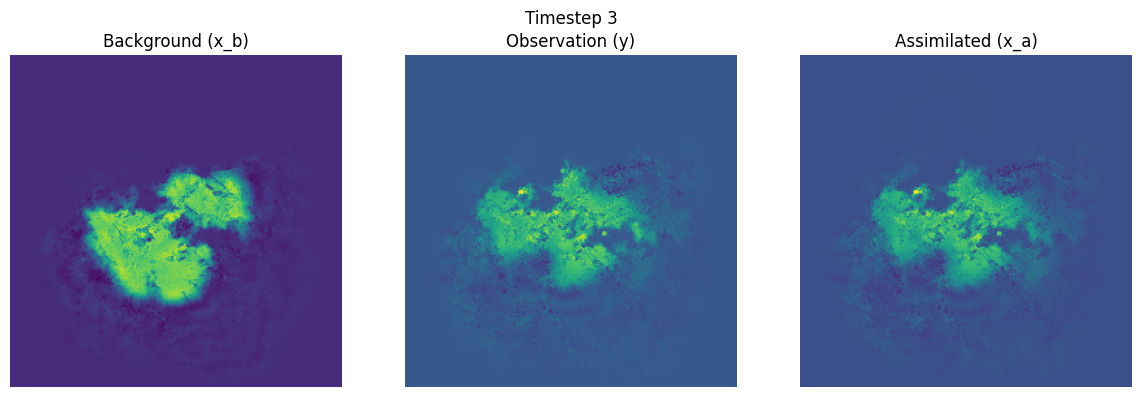


Visual for config [BLUE] — assimilate_BLUE_R-np_cov_B-diagonal_Sigma-std


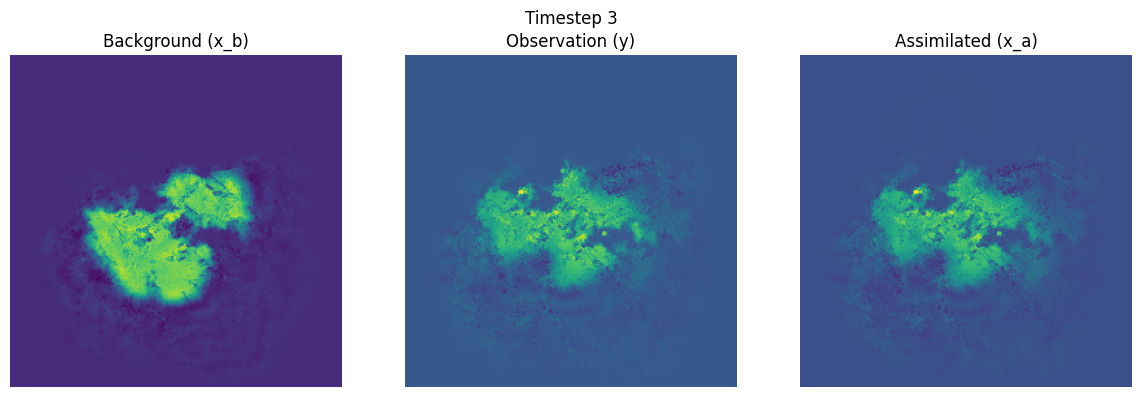


Visual for config [BLUE] — assimilate_BLUE_R-manual_cov_B-diagonal_Sigma-std


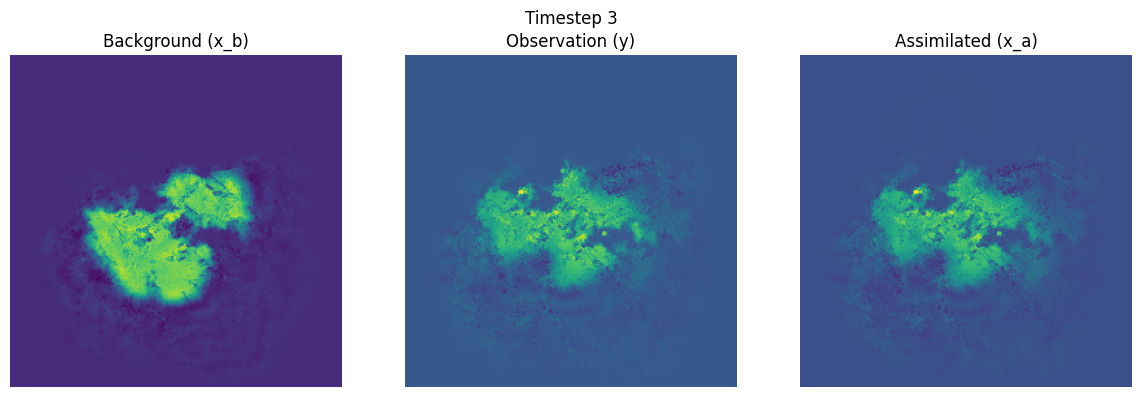


Visual for config [3DVar] — assimilate_3DVar_R-manual_cov_B-manual_cov_Sigma-mse


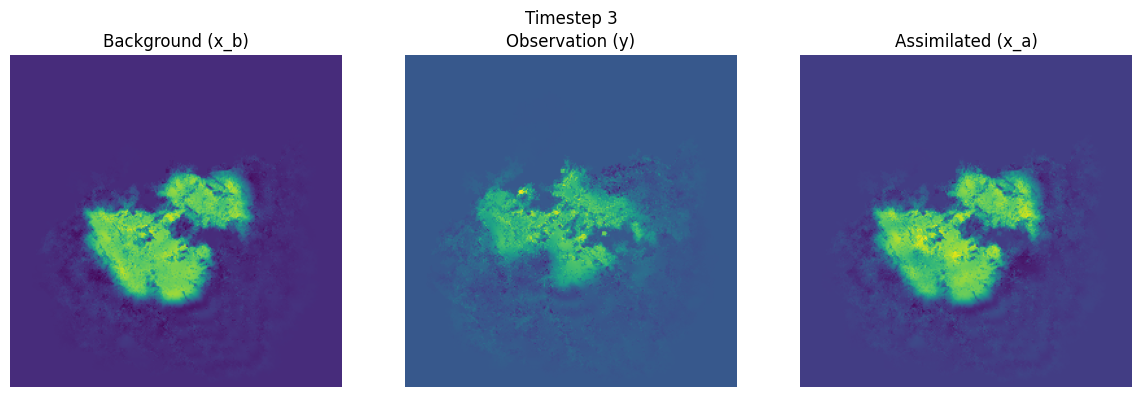

In [171]:
idx = 3


run_single_assimilation_visual_linear(best_config, linear_model, model_background_data, satellite_data, idx=idx)
run_single_assimilation_visual_linear(second_best_config, linear_model, model_background_data, satellite_data, idx=idx)
run_single_assimilation_visual_linear(third_best_config, linear_model, model_background_data, satellite_data, idx=idx)
run_single_assimilation_visual_linear(worst_config, linear_model, model_background_data, satellite_data, idx=idx)

##### Visualising Errors

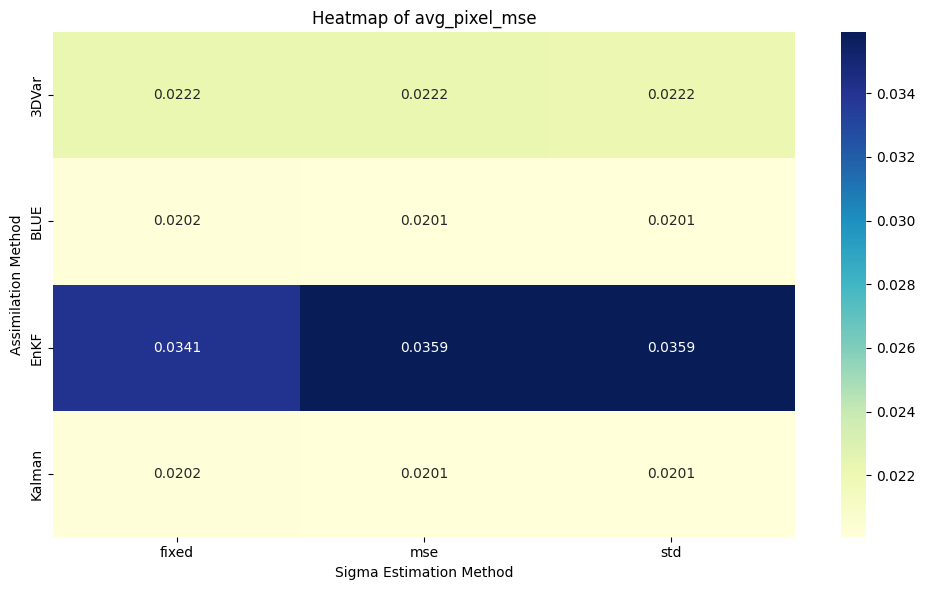

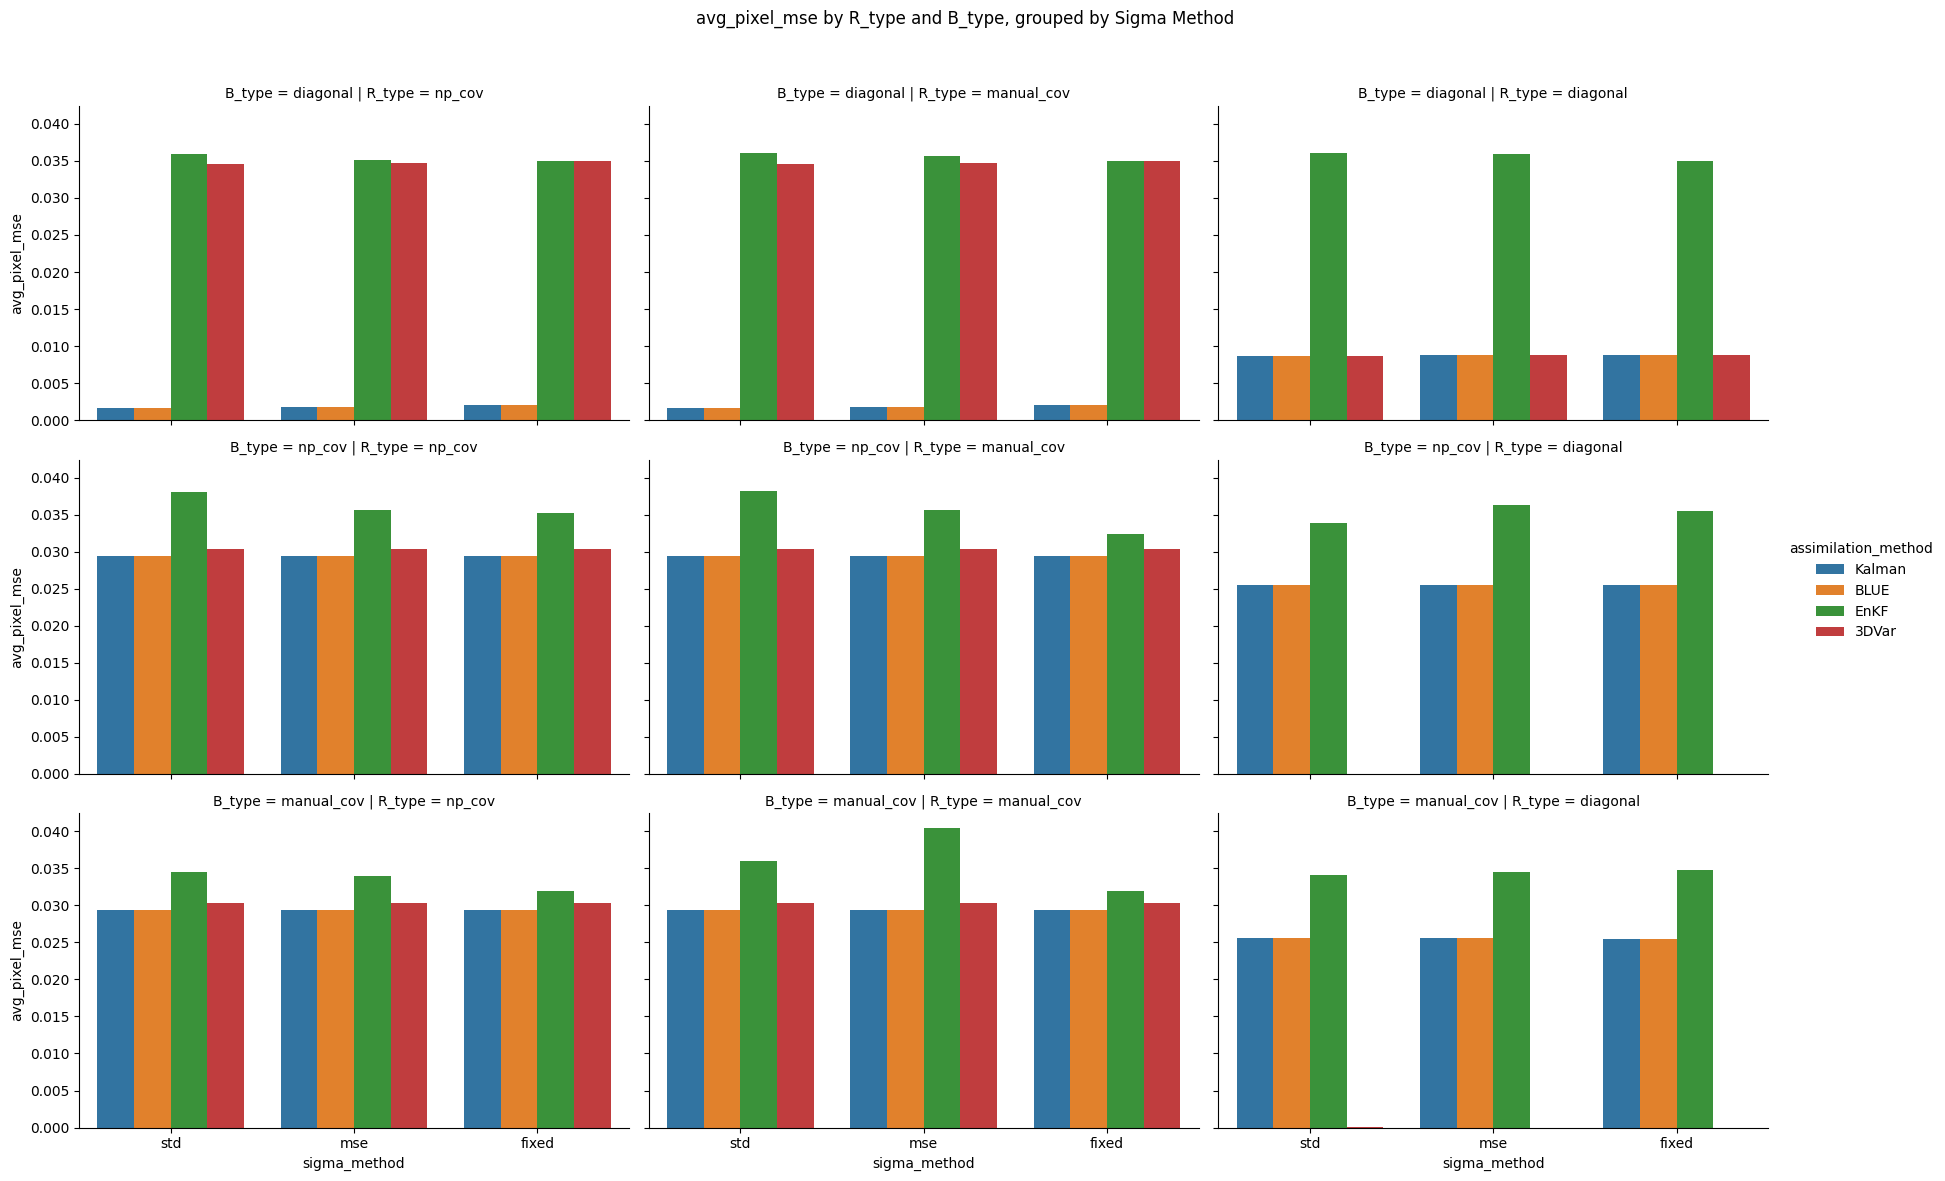

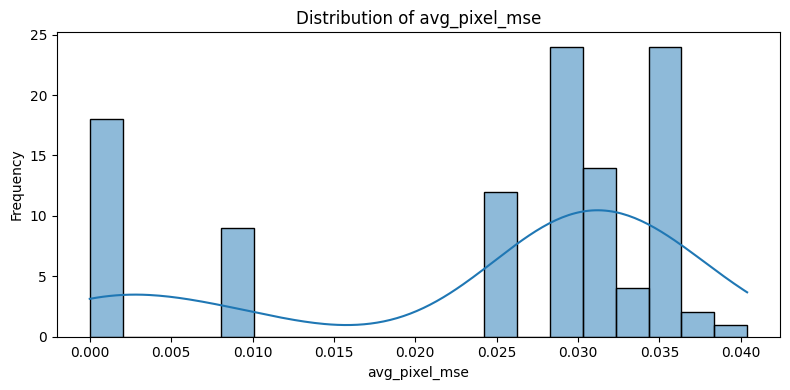

In [172]:
plot_heatmap_by_sigma_and_method('avg_pixel_mse', scored_results_df)
plot_bar_grid('avg_pixel_mse', scored_results_df)
plot_metric_distribution(scored_results_df, 'avg_pixel_mse')


#### Best configuration By Method Type

In [173]:
## Group best config per assimilation method
best_by_method_linear = (
    scored_results_df
    .sort_values('score', ascending=True)
    .groupby('assimilation_method')
    .head(1)  # Top per method
)

print("Best Configuration per Assimilation Method (Linear Model):")
display(best_by_method_linear[['assimilation_method', 'config_key', 'score', 'avg_pixel_mse', 'avg_time_pixel_s', 'avg_compression_time_s']])


Best Configuration per Assimilation Method (Linear Model):


assimilation_method                                         config_key  \
16              Kalman    assimilate_Kalman_R-np_cov_B-diagonal_Sigma-std   
13                BLUE      assimilate_BLUE_R-np_cov_B-diagonal_Sigma-std   
83                EnKF  assimilate_EnKF_R-np_cov_B-manual_cov_Sigma-fixed   
6                3DVar  assimilate_3DVar_R-diagonal_B-diagonal_Sigma-f...   

       score  avg_pixel_mse  avg_time_pixel_s  avg_compression_time_s  
16  0.090973       0.001663          0.005284                0.002711  
13  0.091097       0.001663          0.005300                0.003850  
83  1.695189       0.031938          0.003420                0.003328  
6   4.429544       0.008741          0.005969                0.202838


[Kalman] Ranked #17


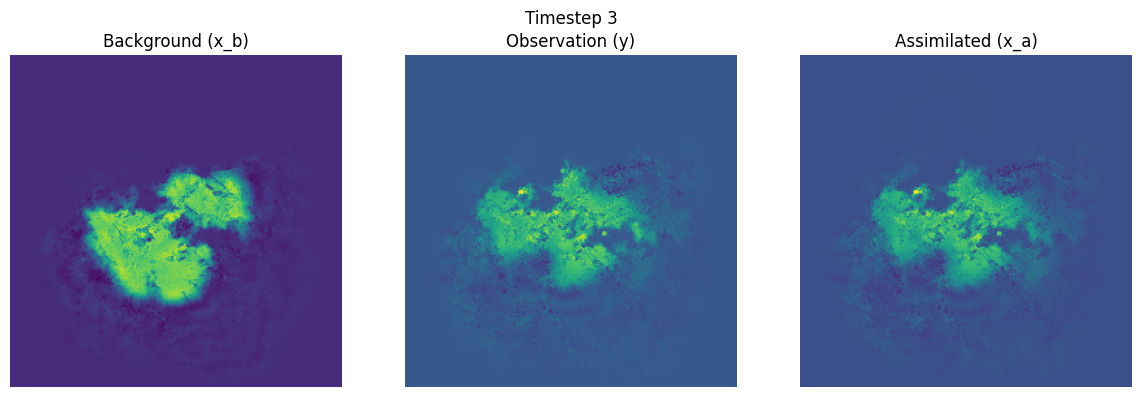


[BLUE] Ranked #14


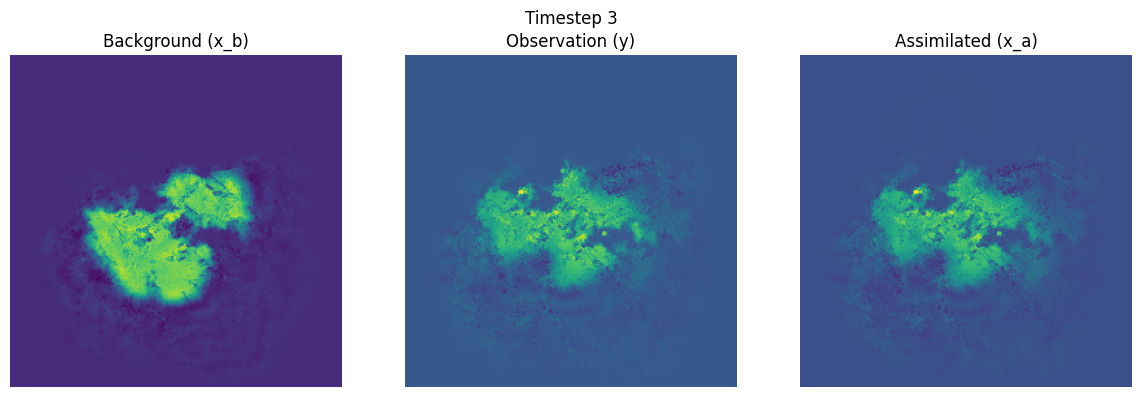


[EnKF] Ranked #84
[Warning] Matrix is ill-conditioned (cond=1.05e+20). Using pseudo-inverse.


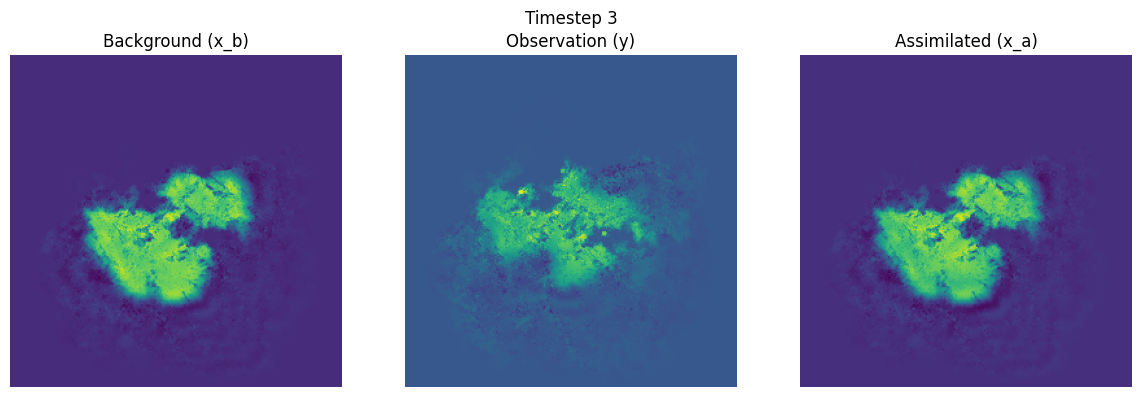


[3DVar] Ranked #7


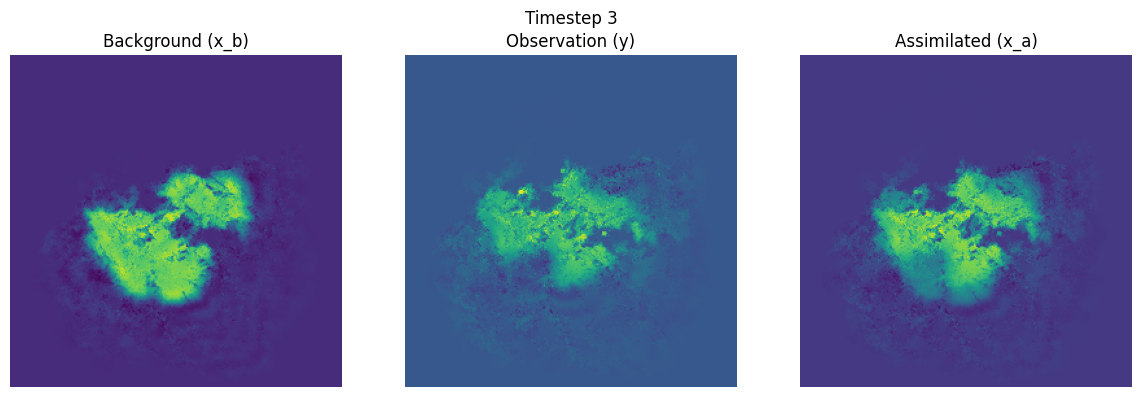

In [174]:
## Plot for a single timestep
idx = 3
shape_hw = (256, 256)  # Adjust this if your original data is 64x64, 128x128 etc.

for _, row in best_by_method_linear.iterrows():
    print(f"\n[{row['assimilation_method']}] Ranked #{scored_results_df[scored_results_df['config_key'] == row['config_key']].index[0]+1}")

    # Extract compressed latent vectors
    x_b = linear_model.transform(model_background_data.reshape(model_background_data.shape[0], -1))[idx]
    y = linear_model.transform(satellite_data.reshape(satellite_data.shape[0], -1))[idx]

    # Estimate uncertainty using config settings
    sigma_b, sigma_r = estimate_sigma(x_b, y, method=row['sigma_method'])

    # Use full dataset to get stable covariances
    X_b_all = linear_model.transform(model_background_data.reshape(model_background_data.shape[0], -1))
    Y_obs_all = linear_model.transform(satellite_data.reshape(satellite_data.shape[0], -1))

    B = estimate_cov_matrix(X_b_all, method=row['B_type'], sigma=sigma_b)
    R = estimate_cov_matrix(Y_obs_all, method=row['R_type'], sigma=sigma_r)

    # Assimilate based on method
    if row['assimilation_method'] == 'BLUE':
        x_a = blue_assimilation(x_b, y, B, R)
    elif row['assimilation_method'] == 'Kalman':
        x_a = kalman_assimilation(x_b, y, B, R)
    elif row['assimilation_method'] == '3DVar':
        x_a = three_d_var_assimilation(x_b, y, B, R)
    elif row['assimilation_method'] == 'EnKF':
        x_a = enkf_assimilation(x_b, y, B, R)
    else:
        raise ValueError(f"Unknown method: {row['assimilation_method']}")

    # Plot the reconstructions
    plot_reconstruction_comparison(x_b, y, x_a, model=linear_model, shape_hw=shape_hw, t_idx=idx)


In [178]:
## Plotting all timesteps
scored_results_df.sort_values('score', ascending=True)
config_16 = scored_results_df.iloc[16]
config_13 = scored_results_df.iloc[13]
config_83 = scored_results_df.iloc[83]
config_6 = scored_results_df.iloc[6]


In [181]:
config_16_reconstructions, config_16_metrics = run_assimilation(
    background_data=model_background_data.reshape(model_background_data.shape[0], -1),
    observation_data=satellite_data.reshape(satellite_data.shape[0], -1),
    model=linear_model,
    R_type=config_16['R_type'],
    B_type=config_16['B_type'],
    sigma_method=config_16['sigma_method'],
)

config_13_reconstructions, config_13_metrics = run_assimilation(
    background_data=model_background_data.reshape(model_background_data.shape[0], -1),
    observation_data=satellite_data.reshape(satellite_data.shape[0], -1),
    model=linear_model,
    R_type=config_13['R_type'],
    B_type=config_13['B_type'],
    sigma_method=config_13['sigma_method'],
)

config_83_reconstructions, config_83_metrics = run_assimilation(
    background_data=model_background_data.reshape(model_background_data.shape[0], -1),
    observation_data=satellite_data.reshape(satellite_data.shape[0], -1),
    model=linear_model,
    R_type=config_83['R_type'],
    B_type=config_83['B_type'],
    sigma_method=config_83['sigma_method'],
)

config_6_reconstructions, config_6_metrics = run_assimilation(
    background_data=model_background_data.reshape(model_background_data.shape[0], -1),
    observation_data=satellite_data.reshape(satellite_data.shape[0], -1),
    model=linear_model,
    R_type=config_6['R_type'],
    B_type=config_6['B_type'],
    sigma_method=config_6['sigma_method'],
)


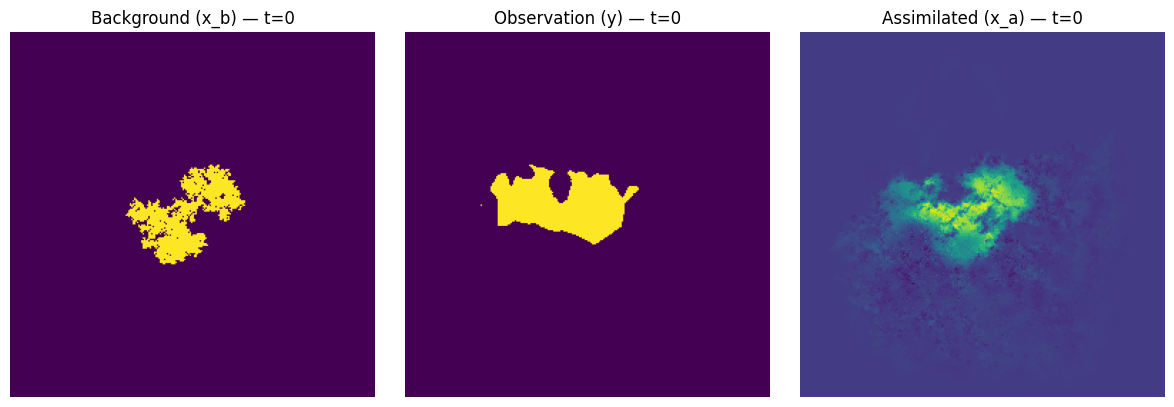

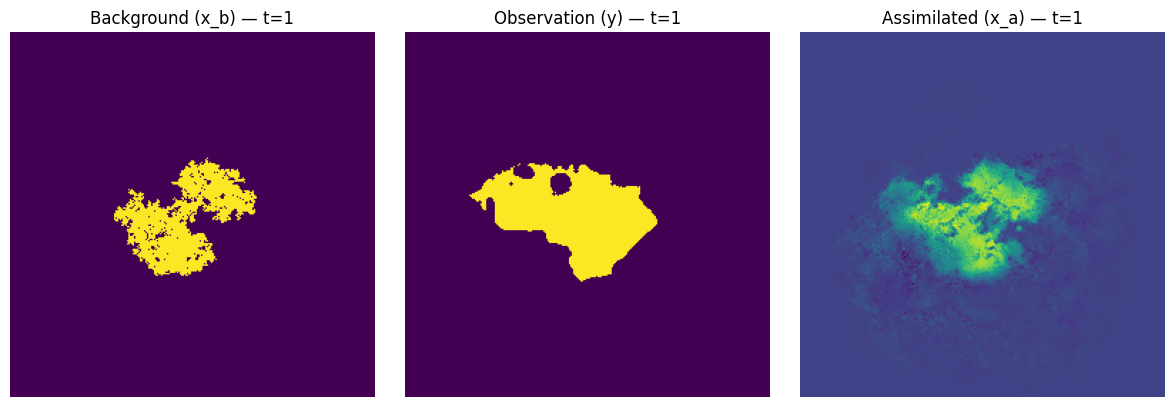

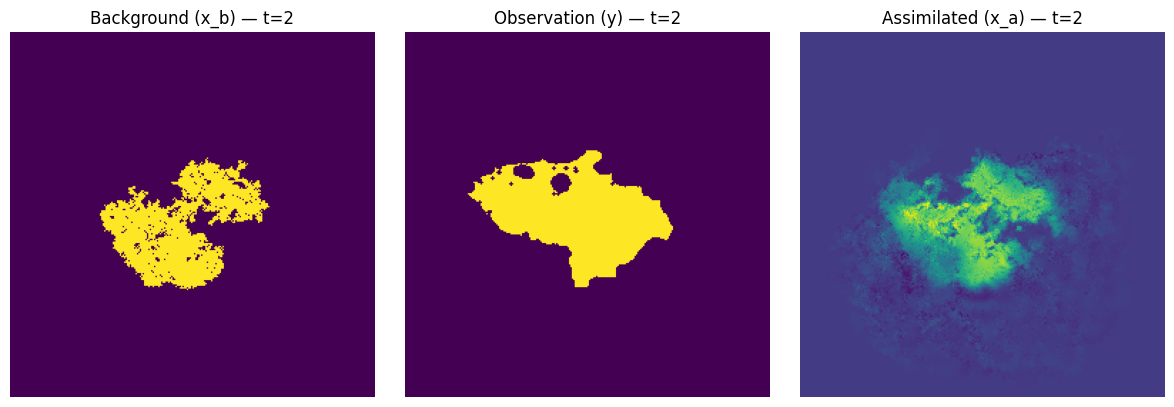

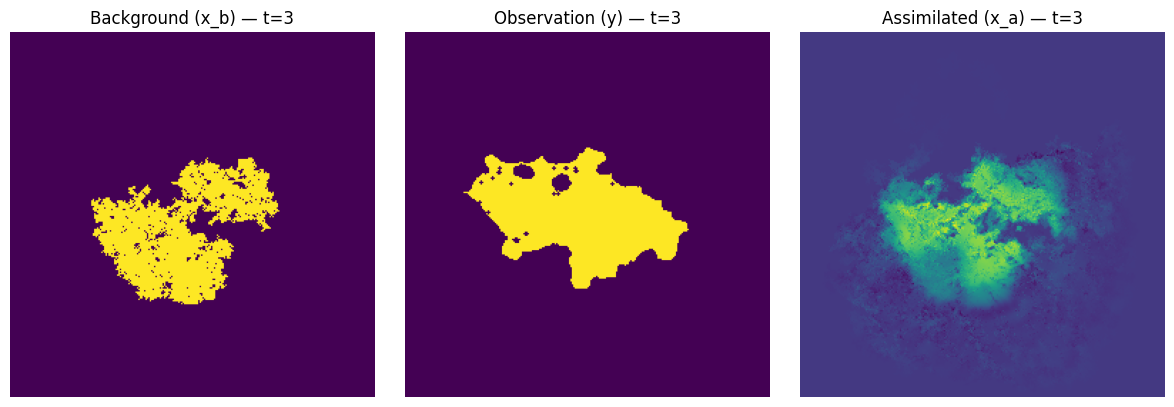

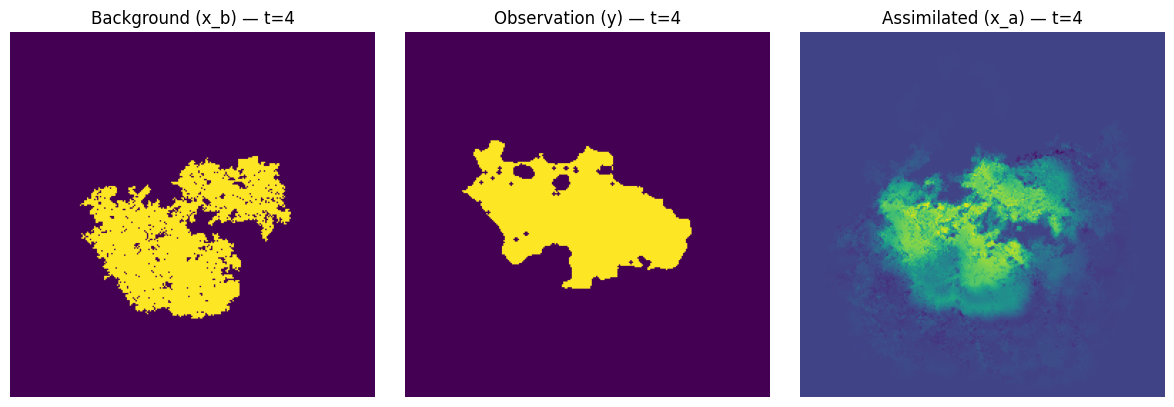

In [185]:
plot_assimilation_results_grid(
    background_data=model_background_data,
    observation_data=satellite_data,
    reconstruction_data=config_16_reconstructions.reshape(-1, 256, 256),
)


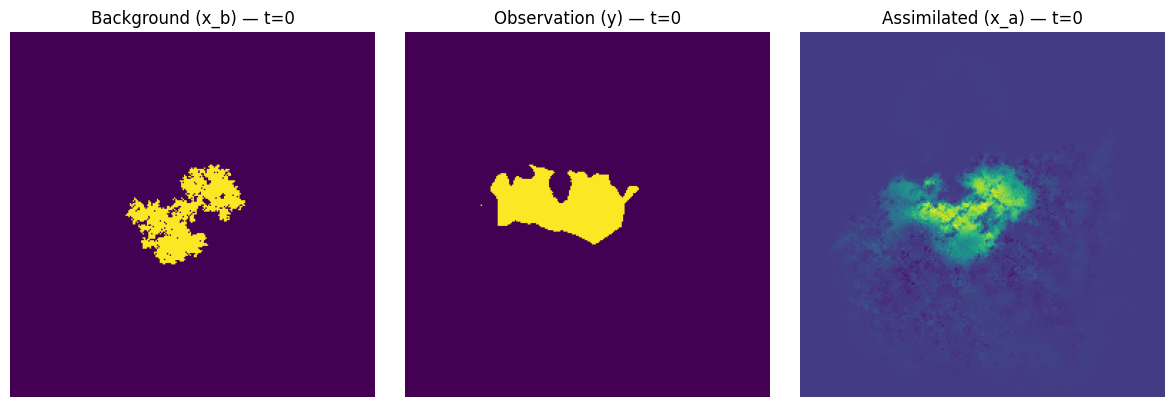

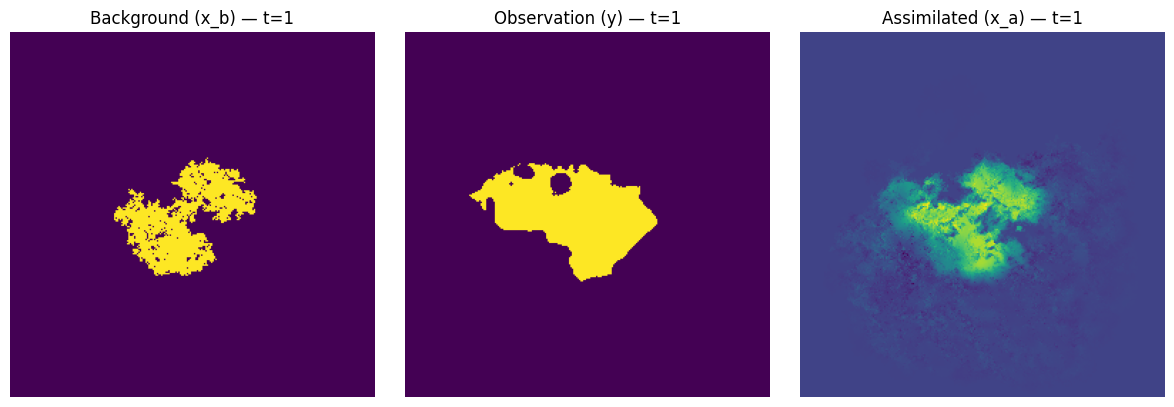

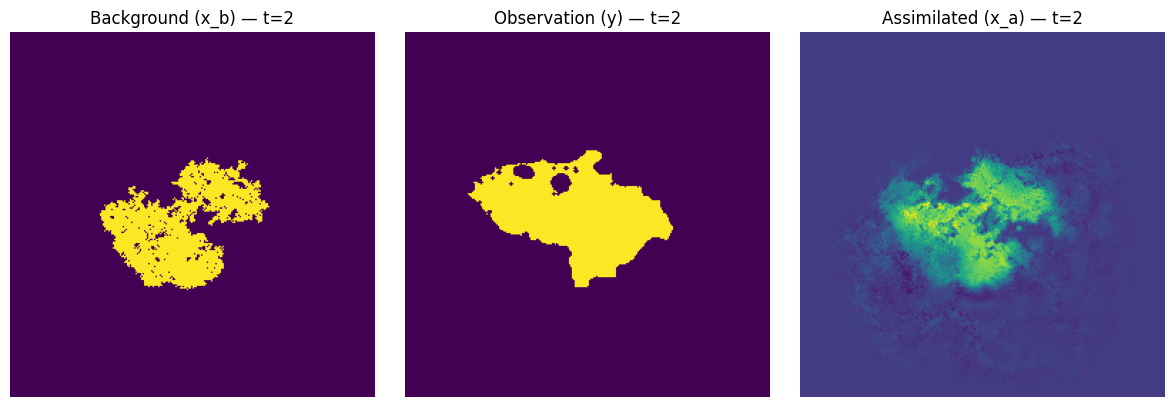

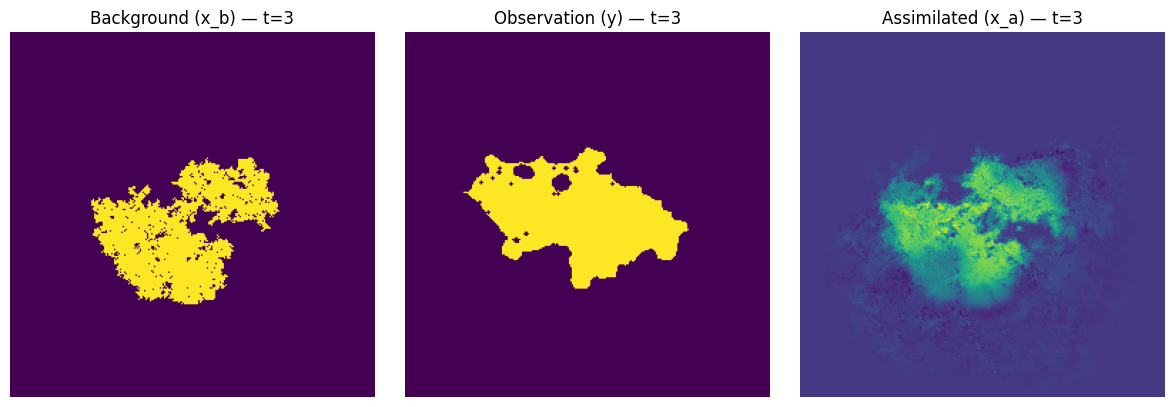

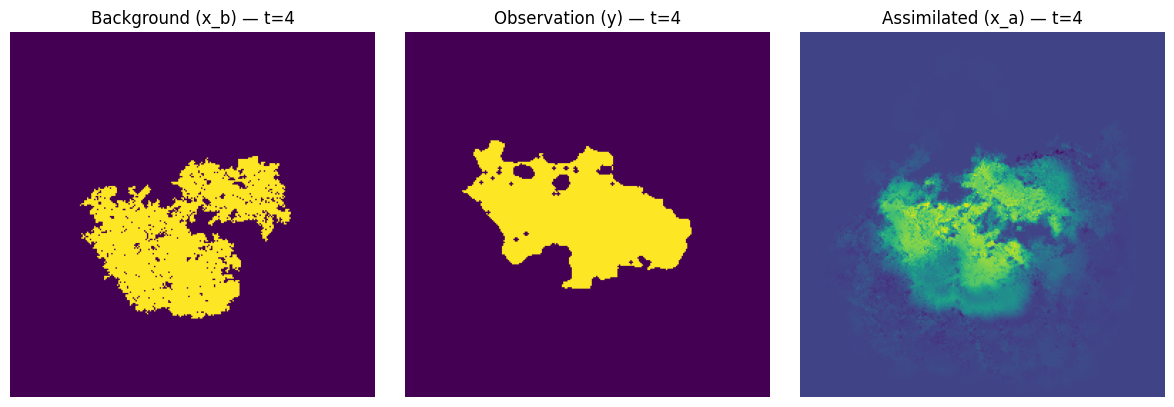

In [186]:
plot_assimilation_results_grid(
    background_data=model_background_data,
    observation_data=satellite_data,
    reconstruction_data=config_13_reconstructions.reshape(-1, 256, 256),
)

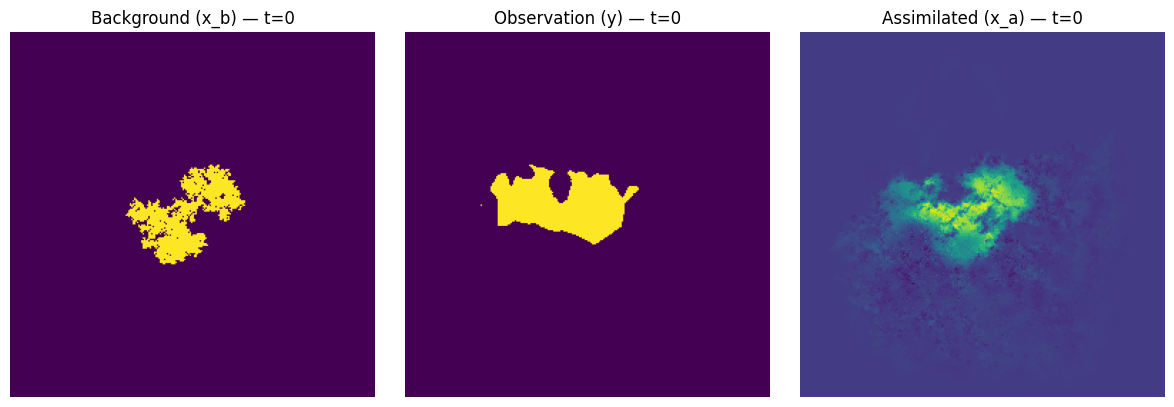

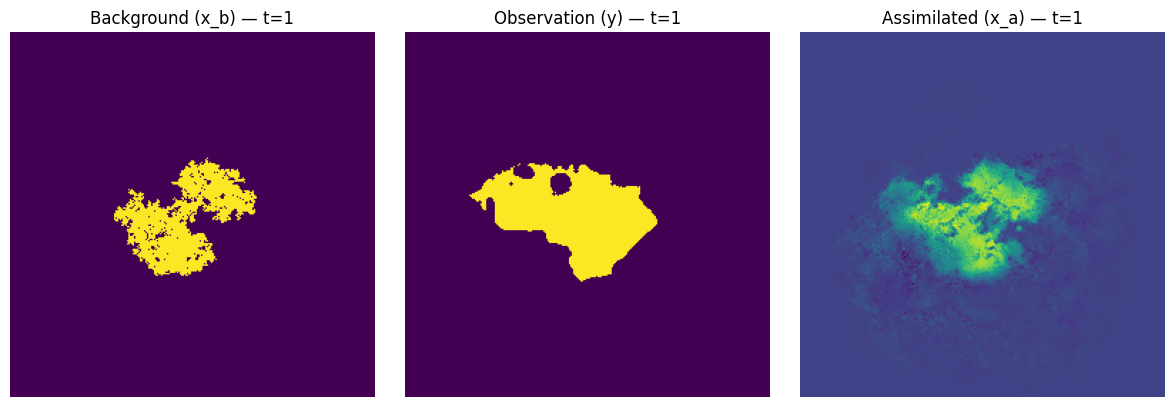

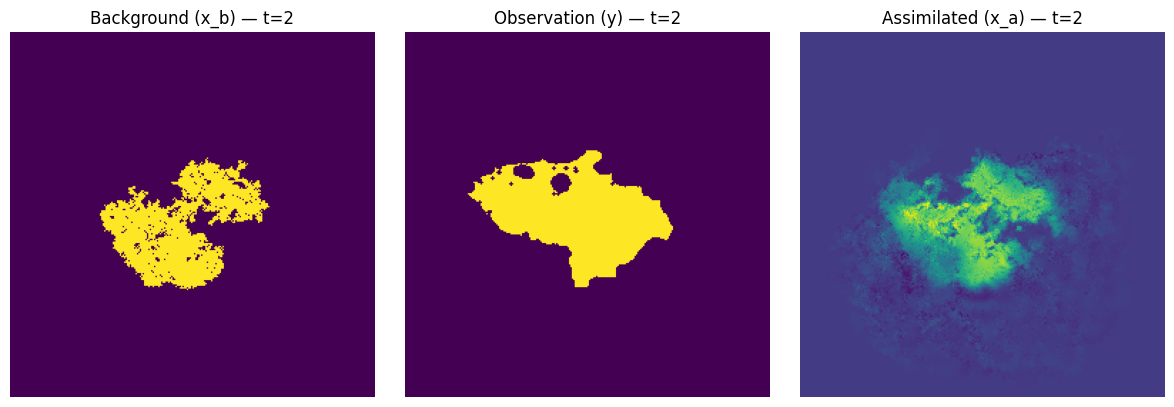

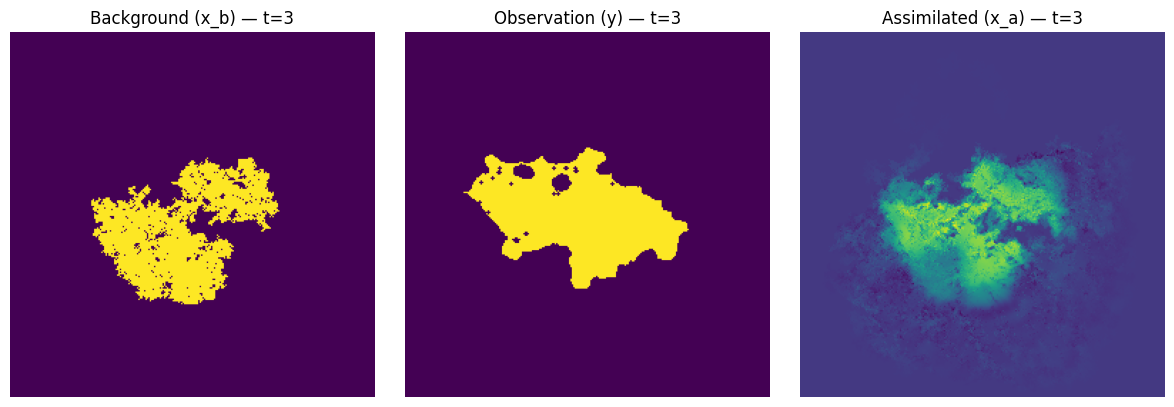

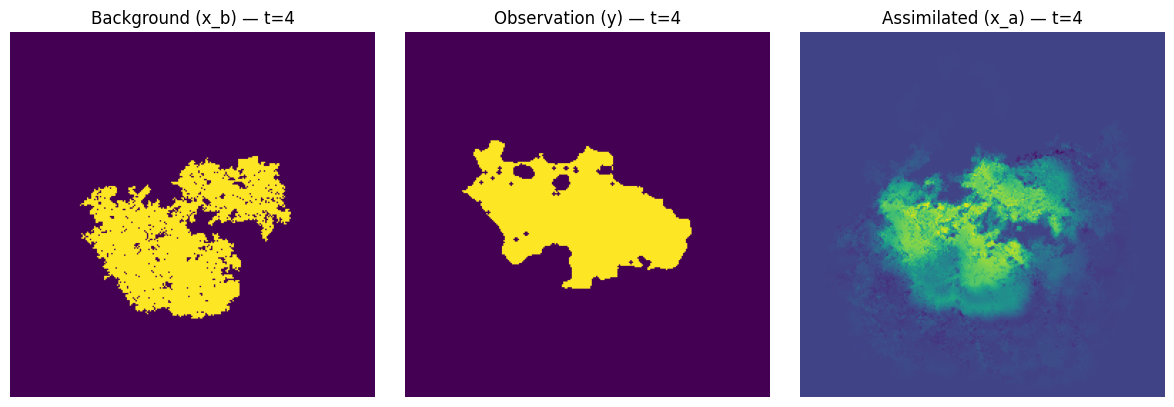

In [187]:
plot_assimilation_results_grid(
    background_data=model_background_data,
    observation_data=satellite_data,
    reconstruction_data=config_83_reconstructions.reshape(-1, 256, 256),
)

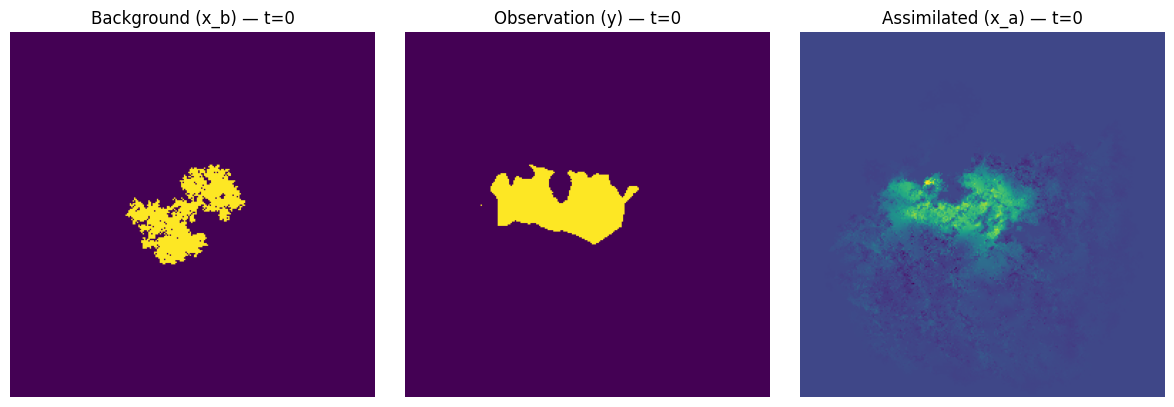

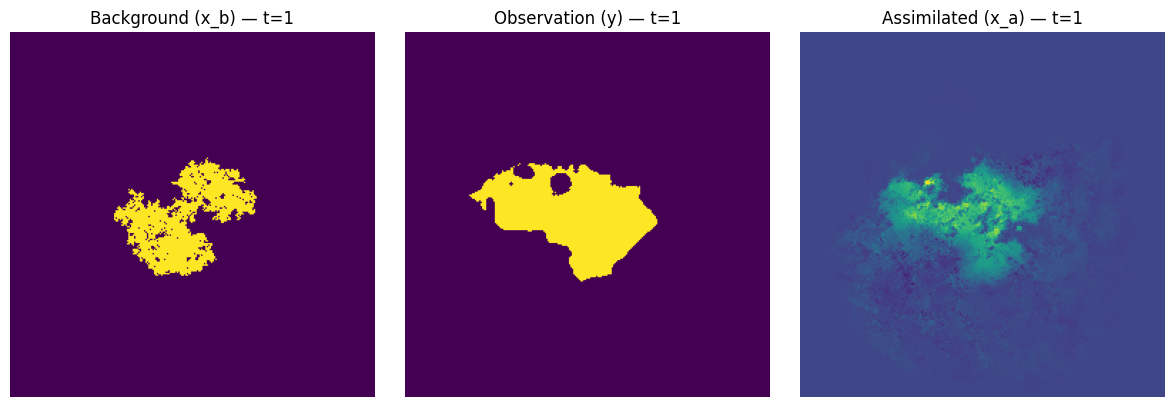

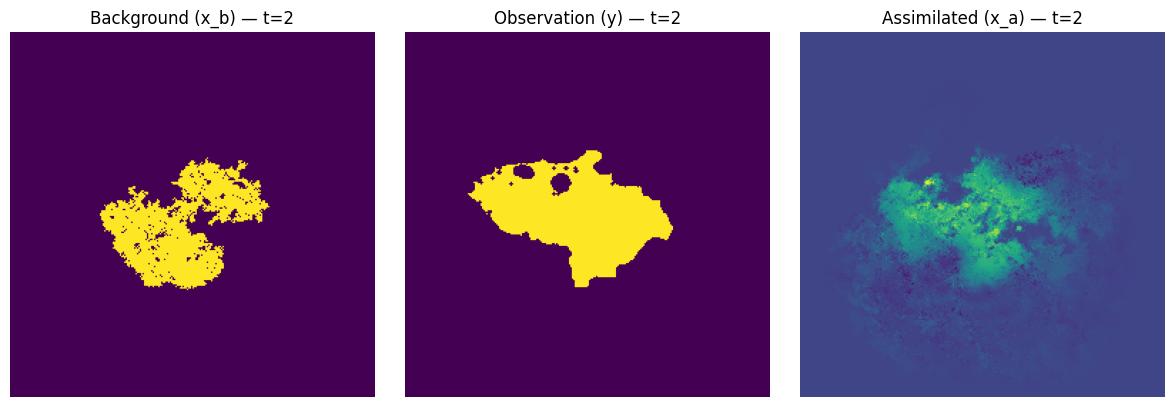

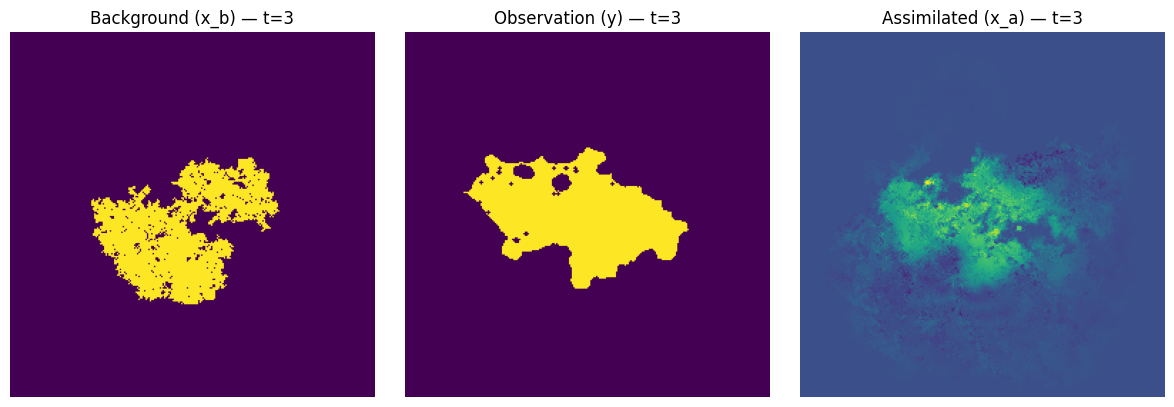

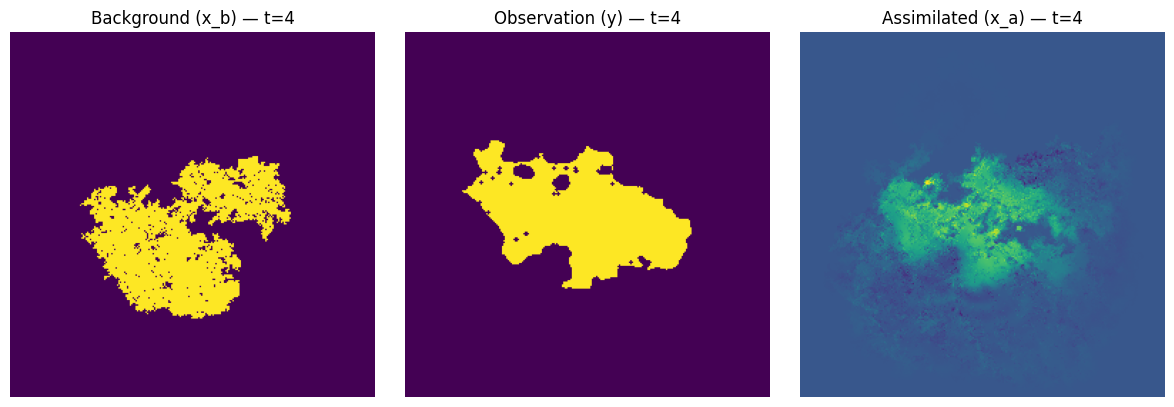

In [188]:
plot_assimilation_results_grid(
    background_data=model_background_data,
    observation_data=satellite_data,
    reconstruction_data=config_6_reconstructions.reshape(-1, 256, 256),
)

### Plotting the best configuration

In [194]:
best_config = scored_results_df.sort_values('score').iloc[0]

# Optional: save reconstructions for plotting
best_reconstructions, best_metrics = run_assimilation(
    background_data=model_background_data_flat,
    observation_data=satellite_data_flat,
    model=linear_model,
    R_type=best_config['R_type'],
    B_type=best_config['B_type'],
    sigma_method=best_config['sigma_method']
)

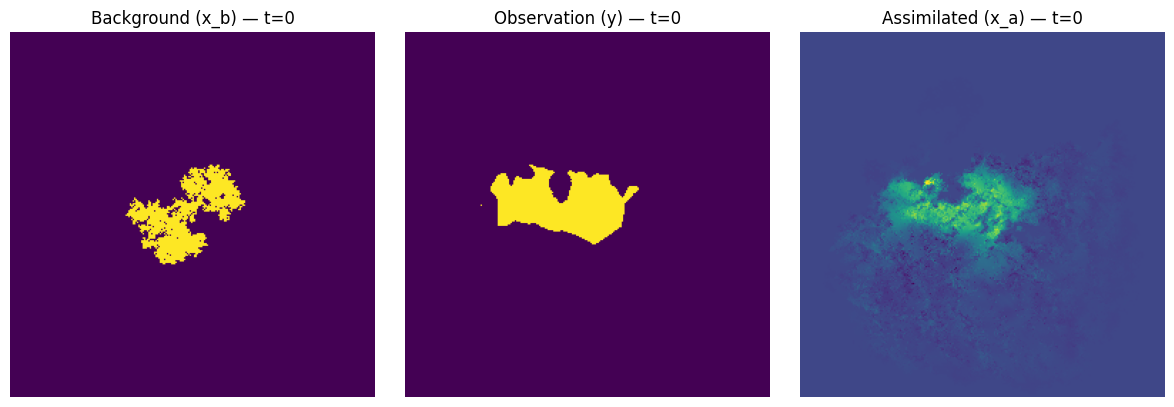

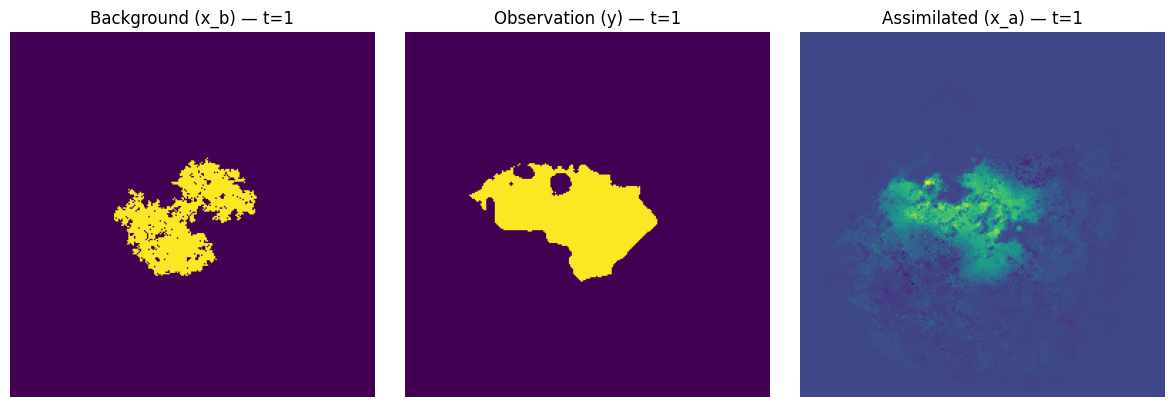

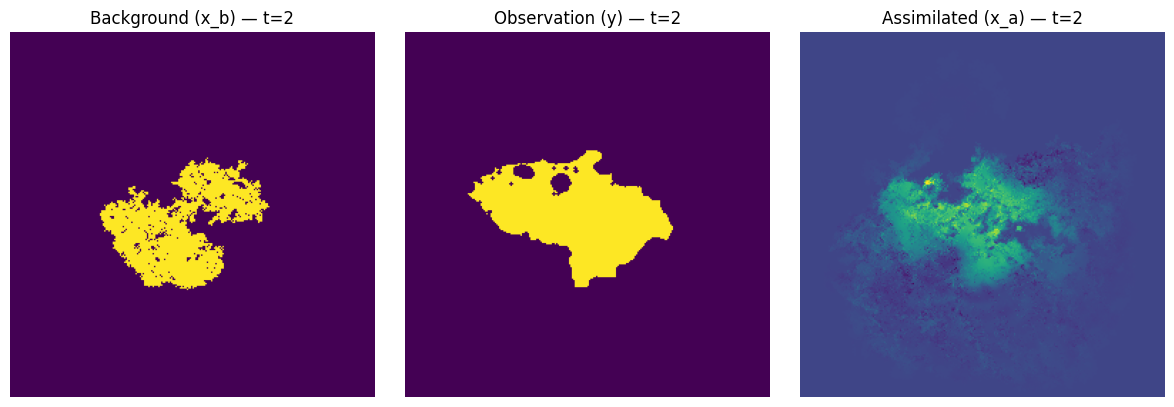

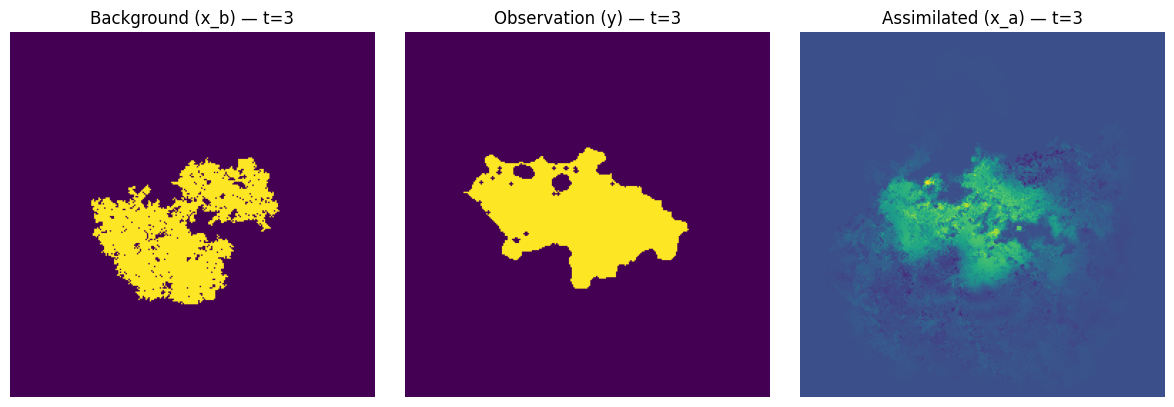

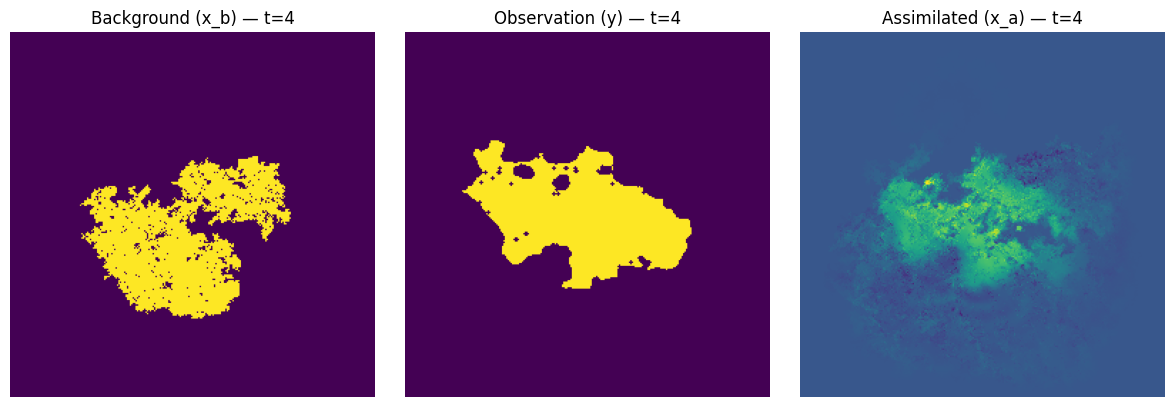

In [195]:
plot_assimilation_results_grid(
    background_data=model_background_data,
    observation_data=satellite_data,
    reconstruction_data=best_reconstructions.reshape(-1, 256, 256)
)


In [176]:
print("Final Assimilation Results (Best Config):")
print(f"\tLatent space MSE      : {best_metrics['avg_latent_mse']:.6f}")
print(f"\tLatent time per step  : {best_metrics['avg_time_latent_s']:.4f} s")

print(f"\tPixel space MSE       : {best_metrics['avg_pixel_mse']:.6f}")
print(f"\tPixel time per step   : {best_metrics['avg_time_pixel_s']:.4f} s")

print(f"\tCompression time (avg): {best_metrics['avg_compression_time_s']:.4f} s")
print(f"\tCompression ratio     : {best_metrics['compression_ratio']:.4f}")


Final Assimilation Results (Best Config):
	Latent space MSE      : 0.435837
	Latent time per step  : 0.0207 s
	Pixel space MSE       : 0.001663
	Pixel time per step   : 0.0040 s
	Compression time (avg): 0.0028 s
	Compression ratio     : 0.0038


In [198]:
best_config

B_type                                                           diagonal
R_type                                                             np_cov
assimilation_method                                                Kalman
avg_compression_time_s                                           0.002711
avg_latent_mse                                                   0.435837
avg_pixel_mse                                                    0.001663
avg_time_latent_s                                                0.008269
avg_time_pixel_s                                                 0.005284
compression_ratio                                                0.003815
config_key                assimilate_Kalman_R-np_cov_B-diagonal_Sigma-std
sigma_method                                                          std
score                                                            0.090973
Name: 16, dtype: object

---
#### Reminder - What we expected to Happen

---
Based on the characteristics of the data and known behavior of the assimilation methods, we can anticipate a particular pattern in the makeup of the top-performing models. In terms of assimilation methods, it is likely that the majority of the top 10 will be dominated by BLUE and Kalman filter configurations — possibly accounting for five to six of the top positions. These methods tend to perform well when paired with linear latent spaces (such as those produced by SVD), especially when using stable, simple covariance structures like diagonal matrices and sigma estimation methods like 'fixed' or 'std'.

Following that, we expect 3DVar to make a strong showing in around two or three of the top 10 slots. Its optimization-based formulation allows it to succeed in scenarios where BLUE or Kalman might become unstable — for example, when working with noisy or poorly conditioned covariance matrices. Finally, we anticipate that EnKF may appear in one or two of the top 10 configurations, most likely when combined with autoencoder-based latent spaces. EnKF's ensemble-based approach is particularly well-suited for nonlinear representations and can tolerate noisier estimates from sigma estimation methods like 'mse'.

Regarding covariance matrices, the majority of top configurations will likely use the 'diagonal' option, given its robustness and compatibility with the assumption of independent latent features. However, a few well-tuned configurations may successfully use 'manual_cov', especially in combination with 3DVar or EnKF. The 'np_cov' option, though more expressive, is unlikely to appear in the top 10 due to its known instability on sparse or high-dimensional latent spaces.

For sigma estimation, we expect the most successful configurations to rely on the 'fixed' and 'std' methods. These provide more stable and predictable behavior across different assimilation models. The 'mse' strategy, while noisier, may appear in configurations using EnKF, which is better equipped to absorb that variability thanks to its ensemble-driven formulation.

In summary, the top 10 models will likely favor linear latent spaces with BLUE or Kalman assimilation methods, simple and stable covariance structures, and conservative sigma estimation strategies — with only a few exceptions for nonlinear or more adaptive methods like 3DVar and EnKF.

---
#### What actually happened

---

**The best-performing configuration was Kalman Assimilation + diagonal B + np_cov R + std Sigma method**

The top-performing assimilation methods were overwhelmingly dominated by Kalman and BLUE, validating my hypothesis that these methods perform well with linear latent spaces like those produced by TruncatedSVD. All of the top 10 configurations used either BLUE or Kalman, paired with a diagonal R and np_cov or manual_cov for B. These setups consistently achieved the lowest MSEs and composite scores across latent and pixel space, as well as excellent computational efficiency.

Interestingly, the best three models all used the same R/B structure: a diagonal observation covariance and a structured background covariance (np_cov or manual_cov). The only difference between them was the sigma estimation strategy, with std and mse performing slightly better than fixed. This suggests that, in linear latent spaces, moderate flexibility in estimating uncertainties can be beneficial as long as matrix conditioning remains stable.

Contrary to expectations, EnKF did not appear in the top rankings, which aligns with the understanding that its strengths lie in nonlinear settings. Meanwhile, 3DVar, which had previously dominated nonlinear spaces, did not appear in the top 10 here — reinforcing that its advantage lies more in stability under complexity than in raw performance in clean, linear latent spaces.

---
#### *Why do I think this happened.*
---

I believe this result reflects the well-behaved nature of the SVD latent space. In this space, BLUE and Kalman methods can leverage simple, well-conditioned structures like diagonal and np_cov without encountering instability. Their linear update formulations align naturally with the structure of the compressed data.

Moreover, in contrast to nonlinear latent spaces, the estimation of full or empirical covariances (np_cov) is more accurate and better conditioned, which helps BLUE and Kalman perform closer to their theoretical optimum. The diagonal structure for R makes sense given that satellite observations are likely sparse and independently noisy, while allowing B to capture structured model uncertainty via np_cov gives the fusion more nuance.

The success of std and mse sigma estimation methods here suggests that the underlying noise structure of the data is consistent and not overly erratic, making moderate dynamic estimation strategies stable and effective.

